In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, precision_score

data = pd.read_csv('./data/mental_health_and_technology_usage_2024.csv')

# Первичный анализ дата сета


### Посмотрим на первые 5 строк дата сета

In [4]:
data.head()

,User_ID,Age,Gender,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Mental_Health_Status,Stress_Level,Sleep_Hours,Physical_Activity_Hours,Support_Systems_Access,Work_Environment_Impact,Online_Support_Usage
0,USER-00001,23,Female,6.57,6.00,0.68,12.36,Good,Low,8.01,6.71,No,Negative,Yes
1,USER-00002,21,Male,3.01,2.57,3.74,7.61,Poor,High,7.28,5.88,Yes,Positive,No
2,USER-00003,51,Male,3.04,6.14,1.26,3.16,Fair,High,8.04,9.81,No,Negative,No
3,USER-00004,25,Female,3.84,4.48,2.59,13.08,Excellent,Medium,5.62,5.28,Yes,Negative,Yes
4,USER-00005,53,Male,1.20,0.56,0.29,12.63,Good,Low,5.55,4.00,No,Positive,Yes


In [42]:
data.shape

(10000, 14)

### Посмотрим на размер дата сета  и типы данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User_ID                   10000 non-null  object 
 1   Age                       10000 non-null  int64  
 2   Gender                    10000 non-null  object 
 3   Technology_Usage_Hours    10000 non-null  float64
 4   Social_Media_Usage_Hours  10000 non-null  float64
 5   Gaming_Hours              10000 non-null  float64
 6   Screen_Time_Hours         10000 non-null  float64
 7   Mental_Health_Status      10000 non-null  object 
 8   Stress_Level              10000 non-null  object 
 9   Sleep_Hours               10000 non-null  float64
 10  Physical_Activity_Hours   10000 non-null  float64
 11  Support_Systems_Access    10000 non-null  object 
 12  Work_Environment_Impact   10000 non-null  object 
 13  Online_Support_Usage      10000 non-null  object 
dtypes: floa

### Посмотрим на статистику дата сета

In [6]:
data.describe()

,Age,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Sleep_Hours,Physical_Activity_Hours
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,41.518600,6.474341,3.972321,2.515598,7.975765,6.500724,5.003860
std,13.920217,3.169022,2.313707,1.446748,4.042608,1.450933,2.905044
min,18.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000
25%,29.000000,3.760000,1.980000,1.260000,4.520000,5.260000,2.490000
50%,42.000000,6.425000,3.950000,2.520000,7.900000,6.500000,4.990000
75%,54.000000,9.212500,5.990000,3.790000,11.500000,7.760000,7.540000
max,65.000000,12.000000,8.000000,5.000000,15.000000,9.000000,10.000000


### Посмотрим на количество пропущенных значений

In [7]:
data.isnull().sum()

User_ID                     0
Age                         0
Gender                      0
Technology_Usage_Hours      0
Social_Media_Usage_Hours    0
Gaming_Hours                0
Screen_Time_Hours           0
Mental_Health_Status        0
Stress_Level                0
Sleep_Hours                 0
Physical_Activity_Hours     0
Support_Systems_Access      0
Work_Environment_Impact     0
Online_Support_Usage        0
dtype: int64

### Посмотрим на количество дубликатов

In [8]:
print(data.duplicated().sum())

0


### Посмотрим на количество уникальных значений

In [9]:
data.nunique()

User_ID                     10000
Age                            48
Gender                          3
Technology_Usage_Hours       1101
Social_Media_Usage_Hours      801
Gaming_Hours                  501
Screen_Time_Hours            1400
Mental_Health_Status            4
Stress_Level                    3
Sleep_Hours                   501
Physical_Activity_Hours      1001
Support_Systems_Access          2
Work_Environment_Impact         3
Online_Support_Usage            2
dtype: int64

In [10]:
data['Age'].unique()

array([23, 21, 51, 25, 53, 58, 63, 57, 31, 64, 40, 24, 38, 26, 55, 37, 34,
       39, 42, 27, 50, 60, 20, 29, 30, 47, 41, 44, 48, 45, 59, 62, 28, 32,
       49, 33, 18, 36, 19, 22, 35, 46, 56, 54, 61, 52, 65, 43],
      dtype=int64)

### Посмотрим на распределение значений в колонке Age

In [11]:
data['Age'].value_counts()

Age
62    245
59    235
32    231
65    230
45    226
50    224
38    224
25    222
18    220
26    220
53    218
57    218
46    218
21    216
22    216
23    216
49    215
42    214
20    214
52    214
29    213
24    212
27    210
37    208
64    208
41    208
36    207
63    207
34    207
33    206
40    205
56    203
43    203
44    202
55    198
39    197
35    197
58    196
30    196
54    194
51    191
28    190
61    187
48    186
60    186
31    186
47    183
19    178
Name: count, dtype: int64

In [12]:
data['Age'].describe()

count    10000.000000
mean        41.518600
std         13.920217
min         18.000000
25%         29.000000
50%         42.000000
75%         54.000000
max         65.000000
Name: Age, dtype: float64

# Анализ данных

### Функция для визуализации распределения признака


In [13]:
def plot_distribution(data, feature):
    plt.figure(figsize=(10, 6))
    if data[feature].dtype in ['int64', 'float64']:
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')
    else:
        sns.countplot(y=feature, data=data)
        plt.title(f'Distribution of {feature}')
        plt.ylabel('')
    plt.tight_layout()
    plt.show()

### Визуализация распределения признаков


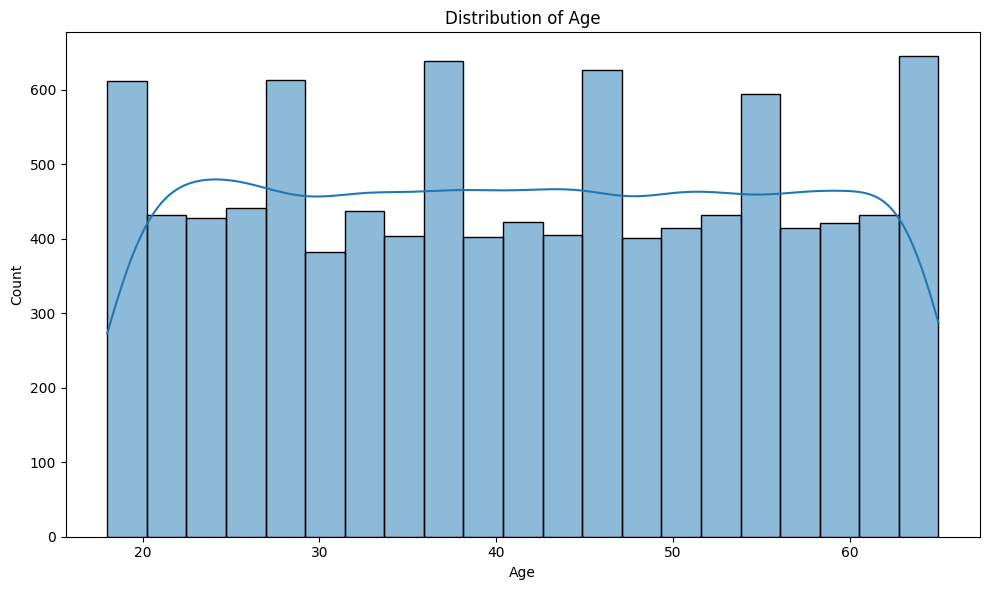

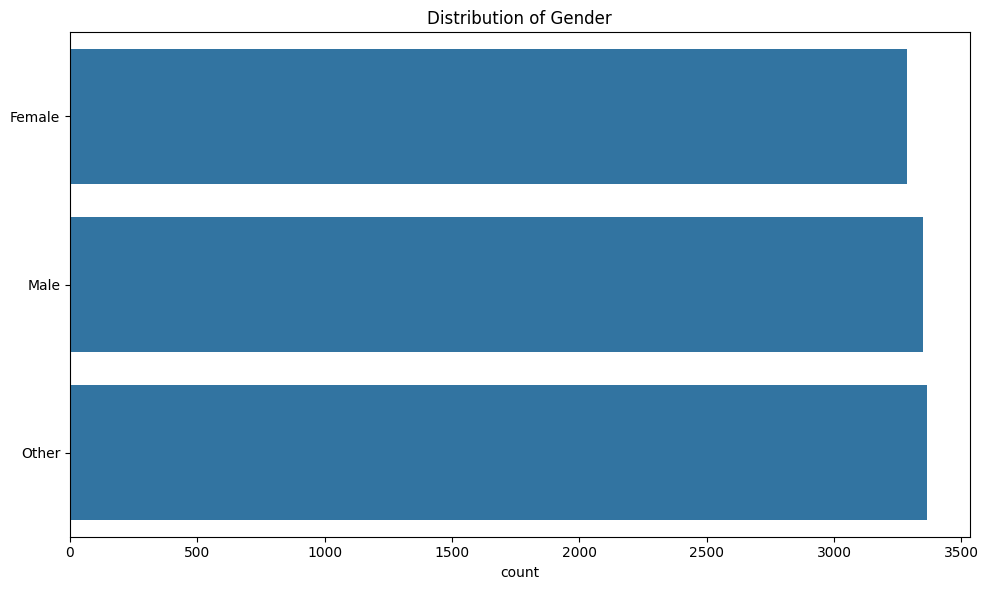

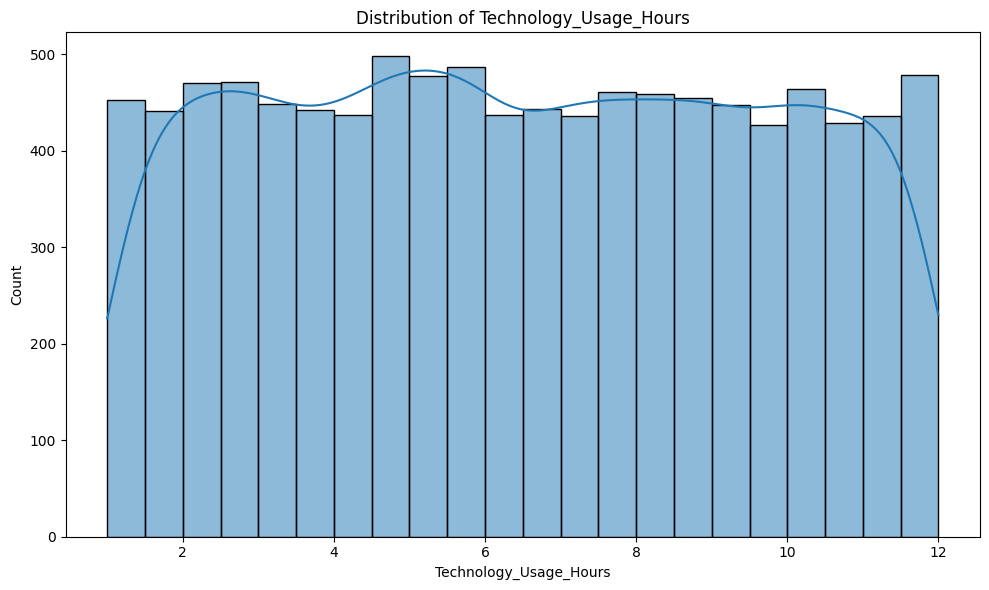

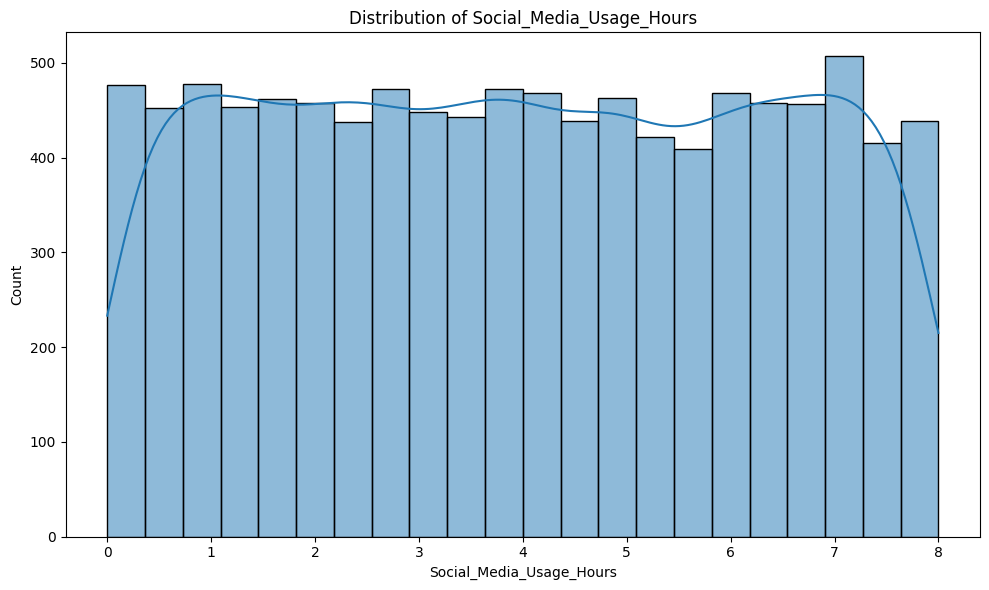

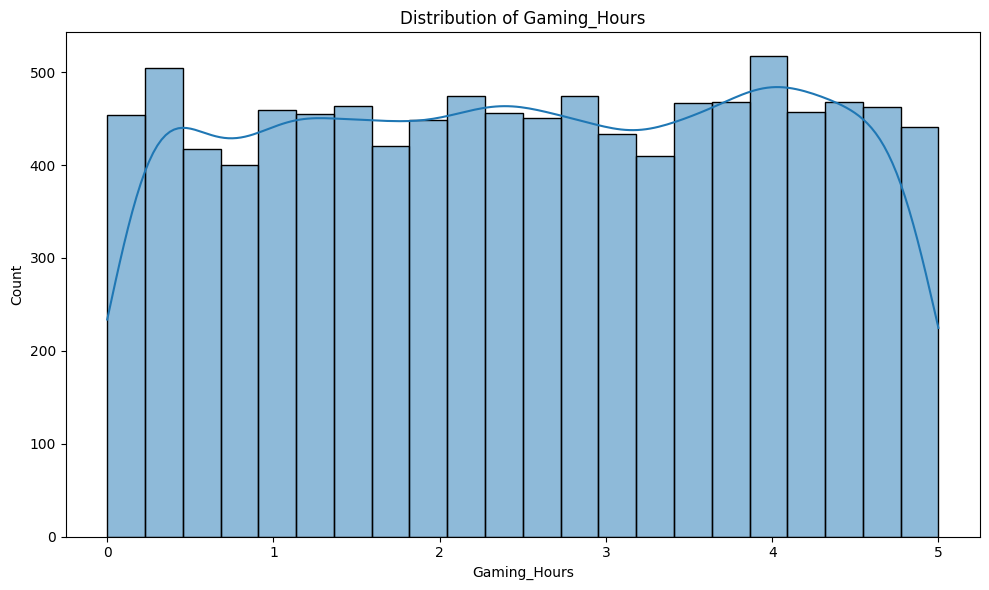

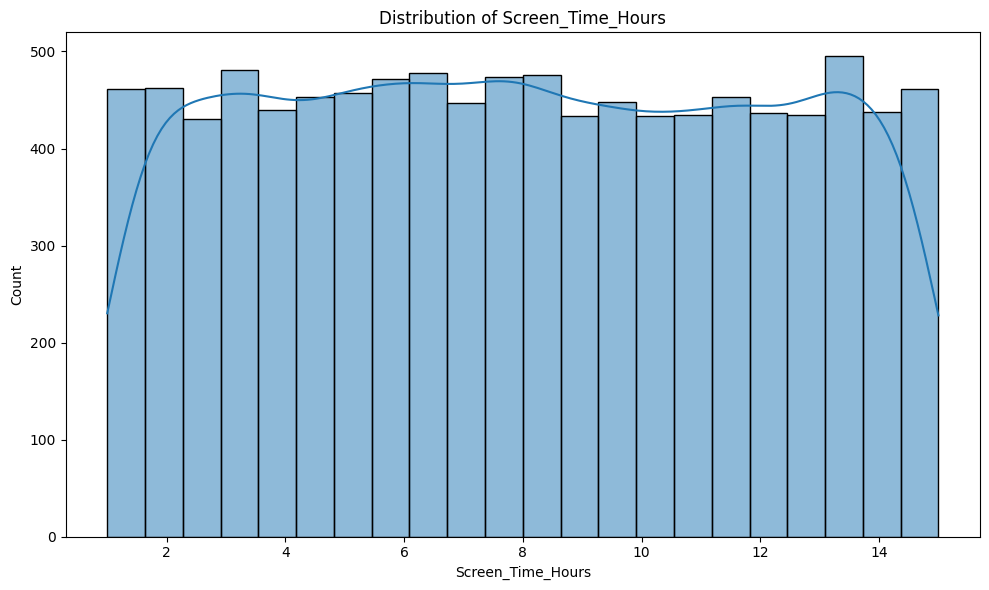

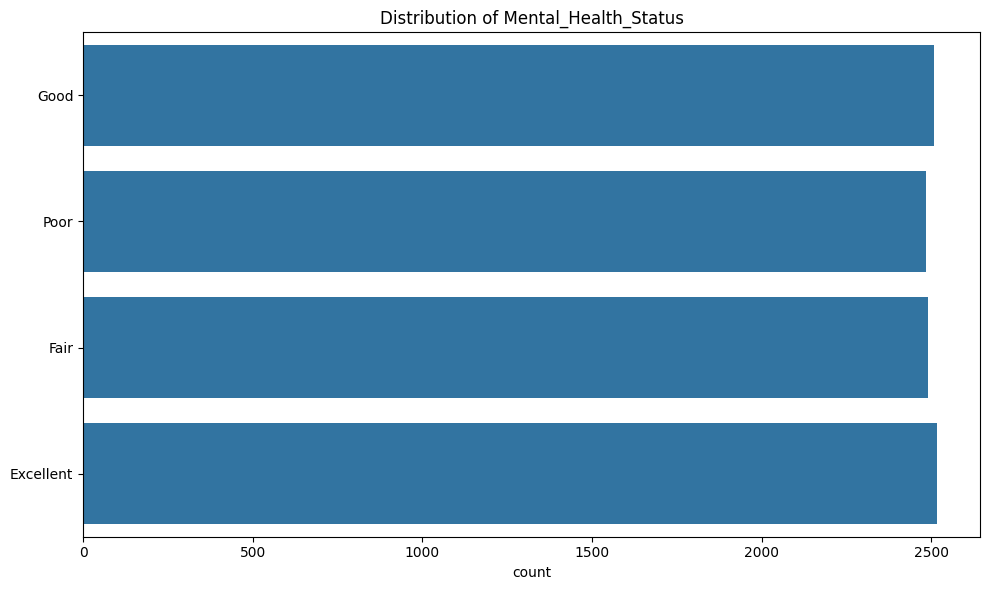

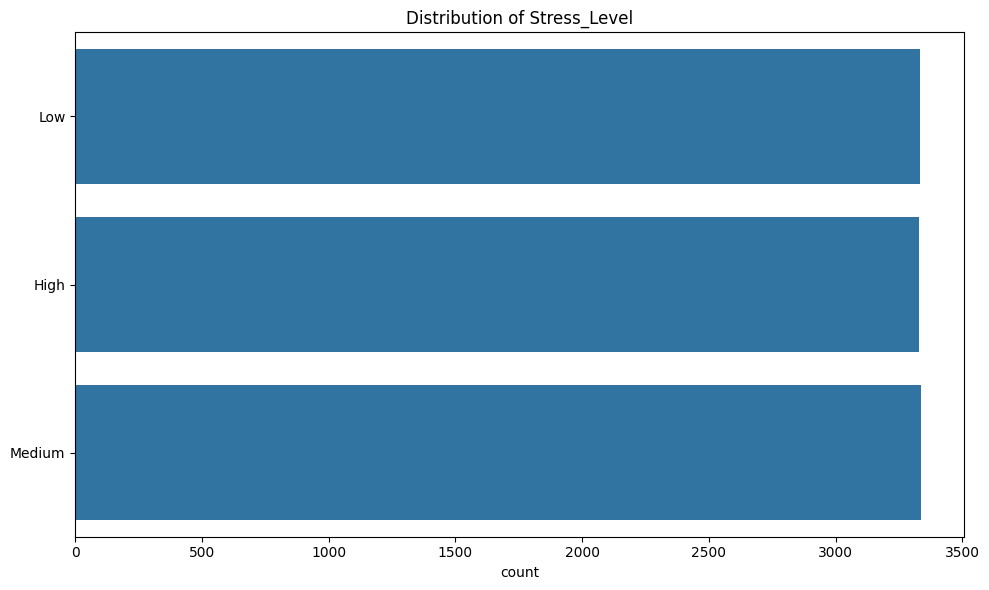

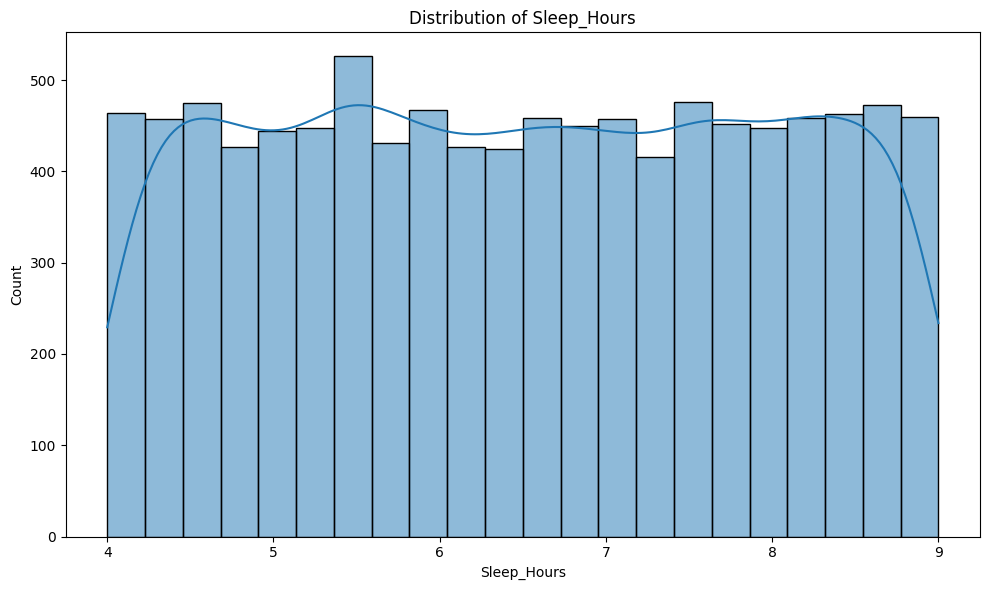

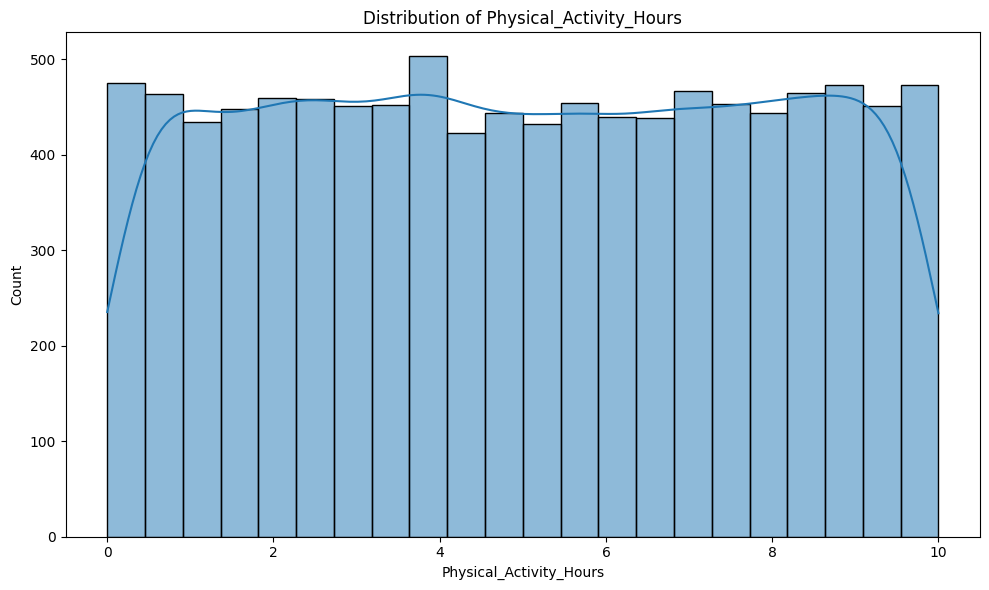

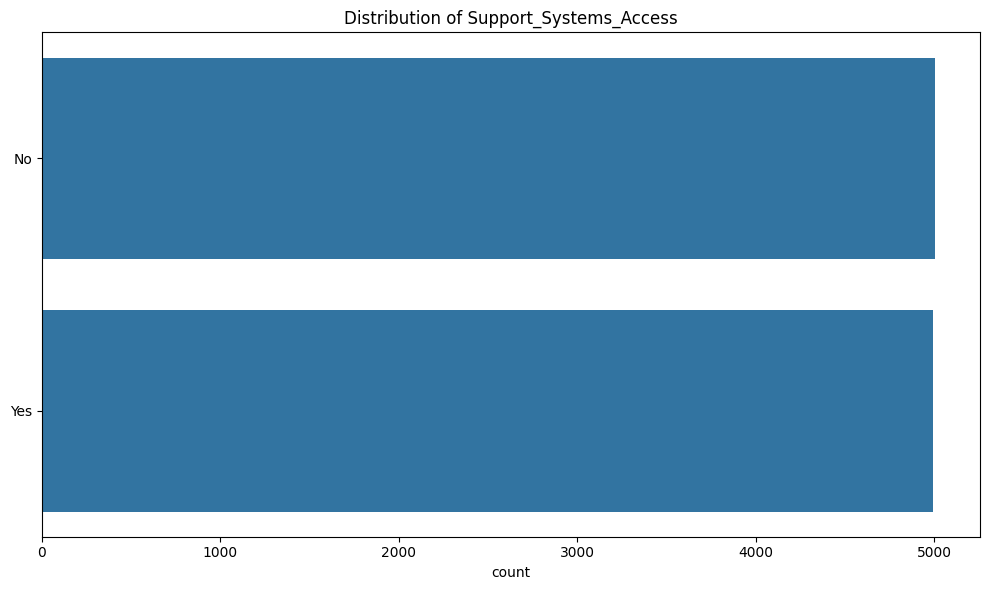

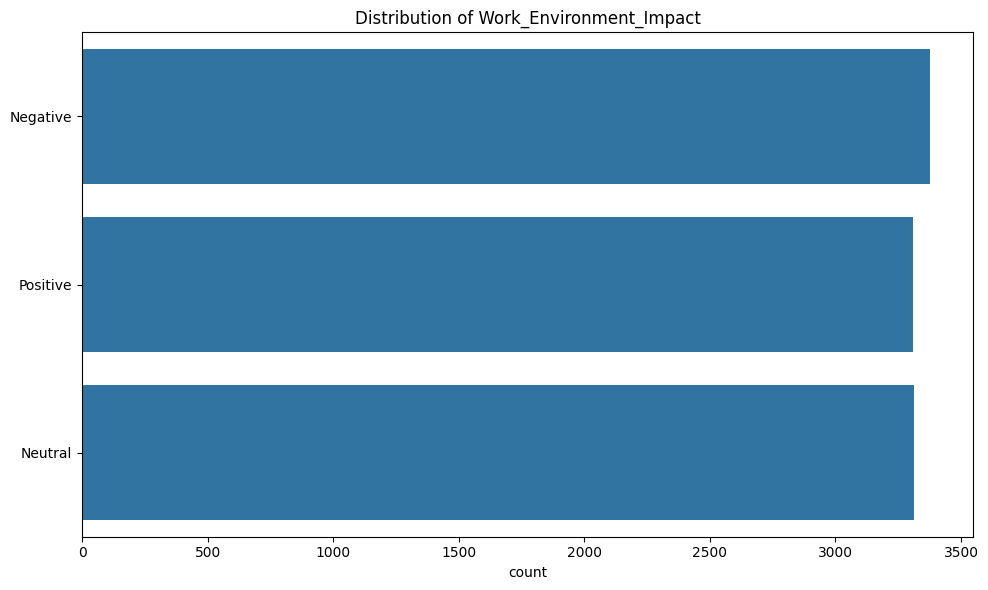

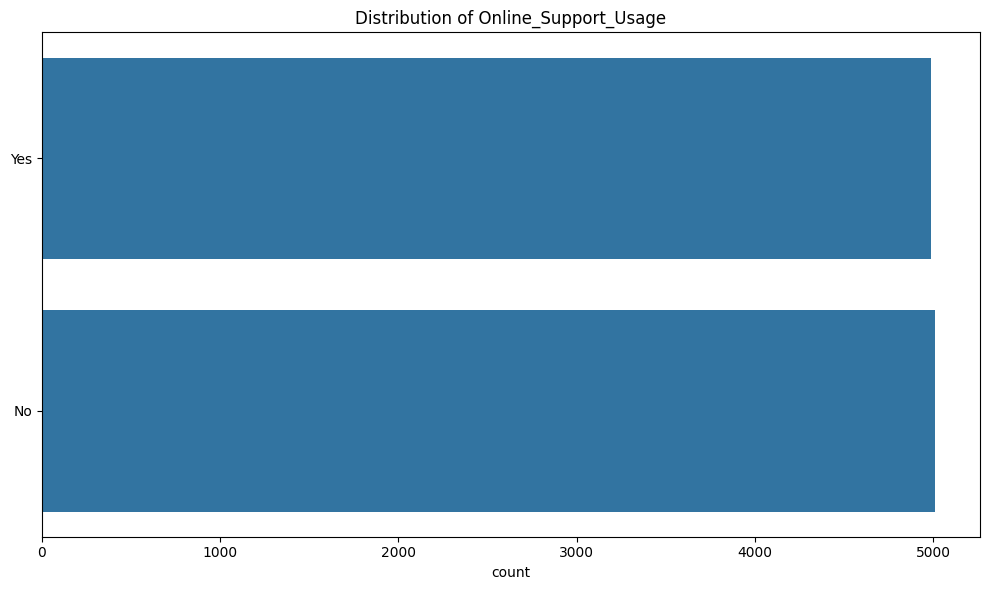

In [14]:
features_to_visualize = [col for col in data.columns if col != 'User_ID']
for feature in features_to_visualize:
    plot_distribution(data, feature)


### Корреляционный анализ для числовых признаков


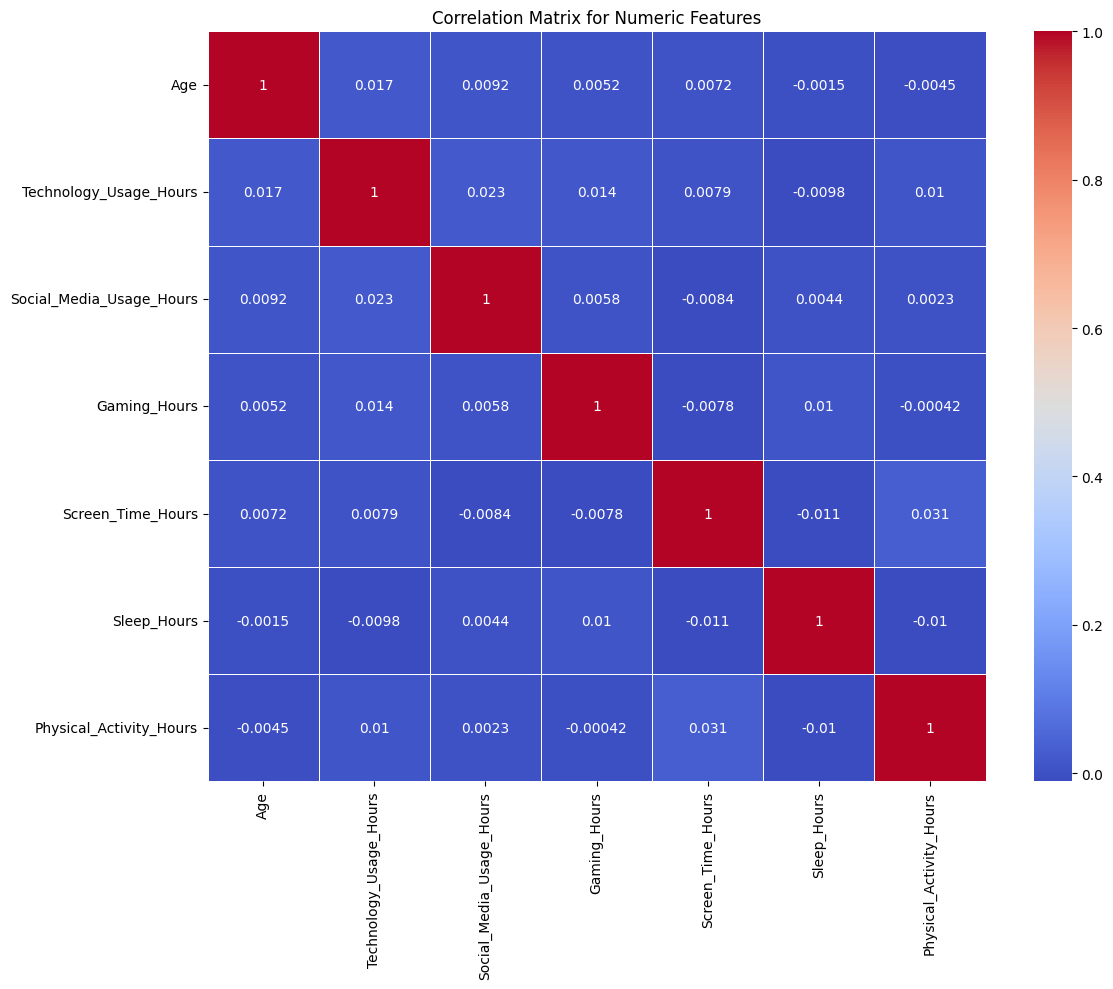

In [15]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Numeric Features')
plt.tight_layout()
plt.show()


### Функция для проведения теста хи-квадрат


In [16]:
def test_uniformity(data, feature, p_value=0.05):
    if data[feature].dtype in ['int64', 'float64']:
        # Для числовых признаков используем биннинг
        _, bin_edges = np.histogram(data[feature], bins='auto')
        observed, _ = np.histogram(data[feature], bins=bin_edges)
        n = len(data[feature])
        expected = np.array([n / len(observed)] * len(observed))
    else:
        # Для категориальных признаков используем частоты категорий
        observed = data[feature].value_counts().values
        n = len(data[feature])
        expected = np.array([n / len(observed)] * len(observed))
    
    chi2, p = stats.chisquare(observed, expected)
    
    return {
        'feature': feature,
        'chi2_statistic': chi2,
        'p_value': p,
        'is_uniform': p > p_value
    }   

### Проведение теста хи-квадрат для всех признаков
- H0: Распределение значений признака равномерно
- H1: Распределение значений признака не равномерно
- Уровень значимости: 0.05

In [17]:
# Проводим тест для всех признаков, кроме User_id
features_to_test = [col for col in data.columns if col != 'User_ID']
results = []

for feature in features_to_test:
    result = test_uniformity(data, feature)
    results.append(result)

In [18]:
# Создаем датафрейм с результатами
results_df = pd.DataFrame(results)

# Сортируем результаты по p-value
results_df = results_df.sort_values('p_value')

results_df

,feature,chi2_statistic,p_value,is_uniform
0,Age,386.0078,1.623409e-69,False
4,Gaming_Hours,35.3044,2.613755e-02,False
8,Sleep_Hours,25.0568,2.447124e-01,True
3,Social_Media_Usage_Hours,23.4200,3.220001e-01,True
1,Gender,1.0376,5.952344e-01,True
11,Work_Environment_Impact,0.8984,6.381385e-01,True
2,Technology_Usage_Hours,17.6340,6.720333e-01,True
5,Screen_Time_Hours,16.1160,7.630984e-01,True
12,Online_Support_Usage,0.0676,7.948638e-01,True
9,Physical_Activity_Hours,14.4616,8.489673e-01,True


### Визуализация результатов теста хи-квадрат


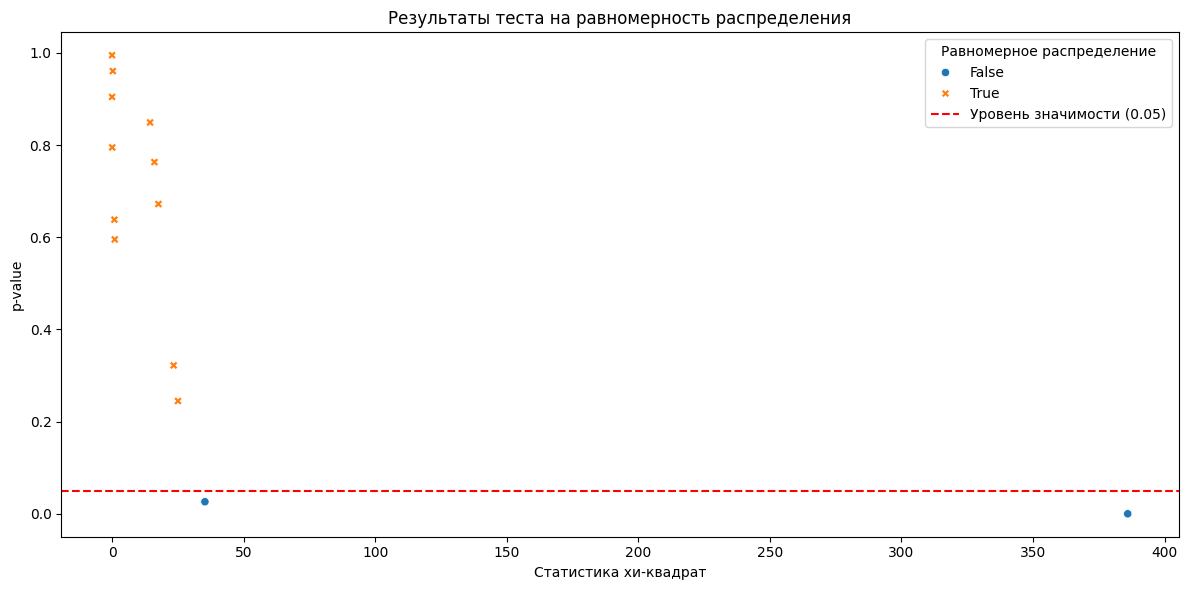

In [19]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='chi2_statistic', y='p_value', hue='is_uniform', style='is_uniform')
plt.title('Результаты теста на равномерность распределения')
plt.xlabel('Статистика хи-квадрат')
plt.ylabel('p-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Уровень значимости (0.05)')
plt.legend(title='Равномерное распределение')
plt.tight_layout()
plt.show()

### Функция для визуализации зависимостей между числовыми и категориальными признаками


In [20]:
def plot_boxplot(data, num_feature, cat_feature):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_feature, y=num_feature, data=data)
    plt.title(f'{num_feature} by {cat_feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Визуализация зависимостей между числовыми и категориальными признаками


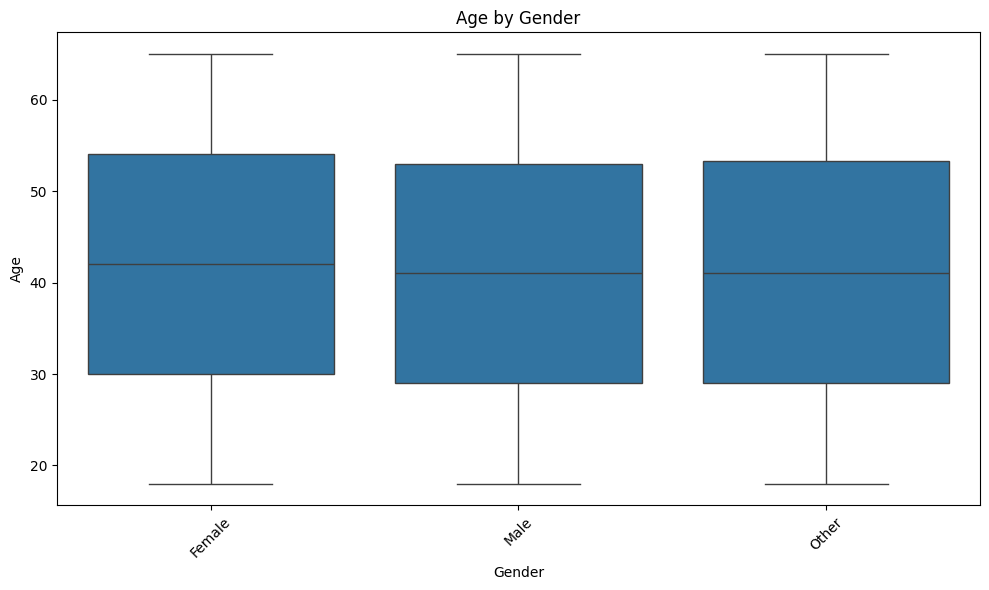

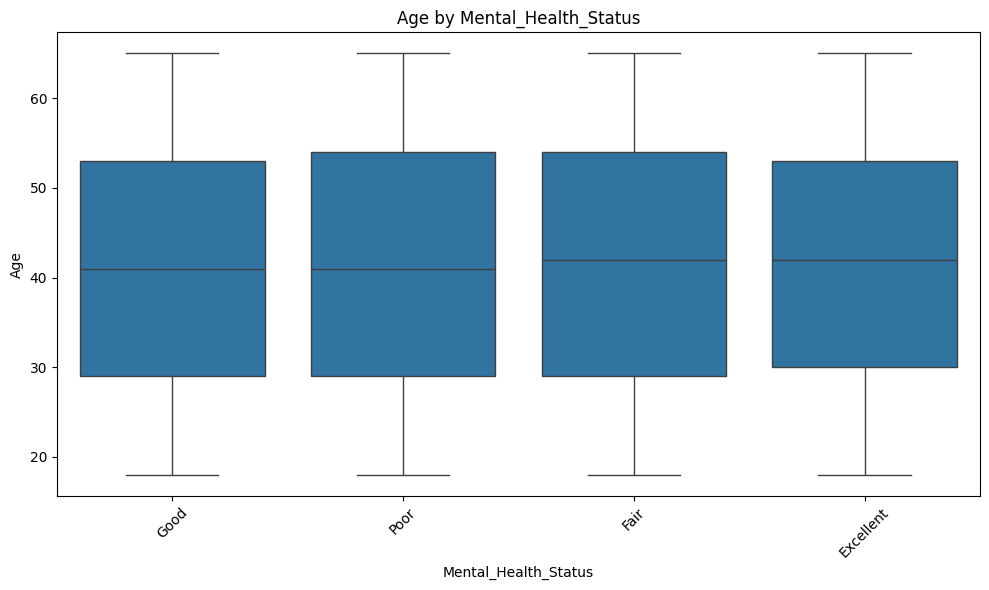

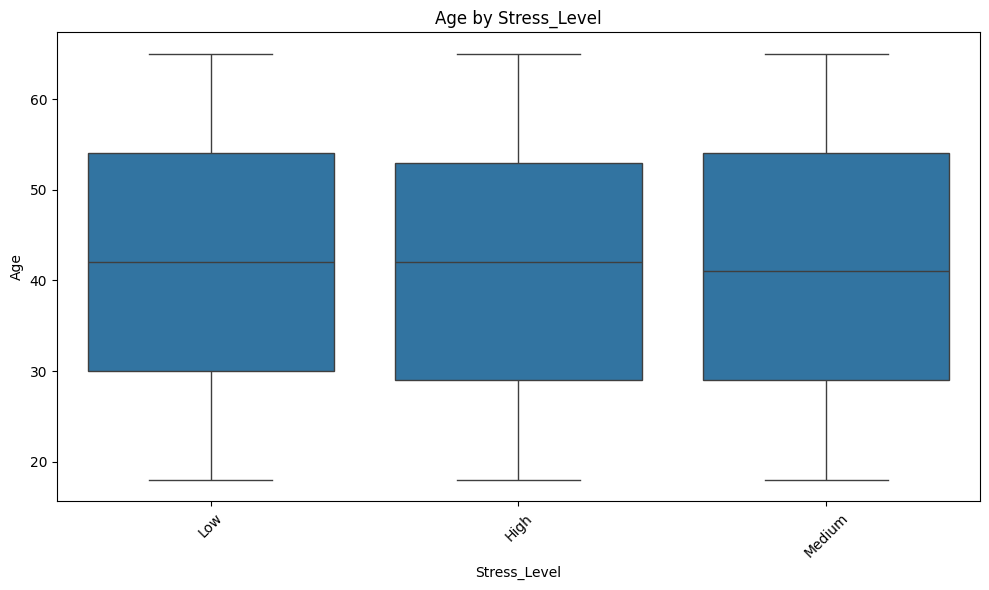

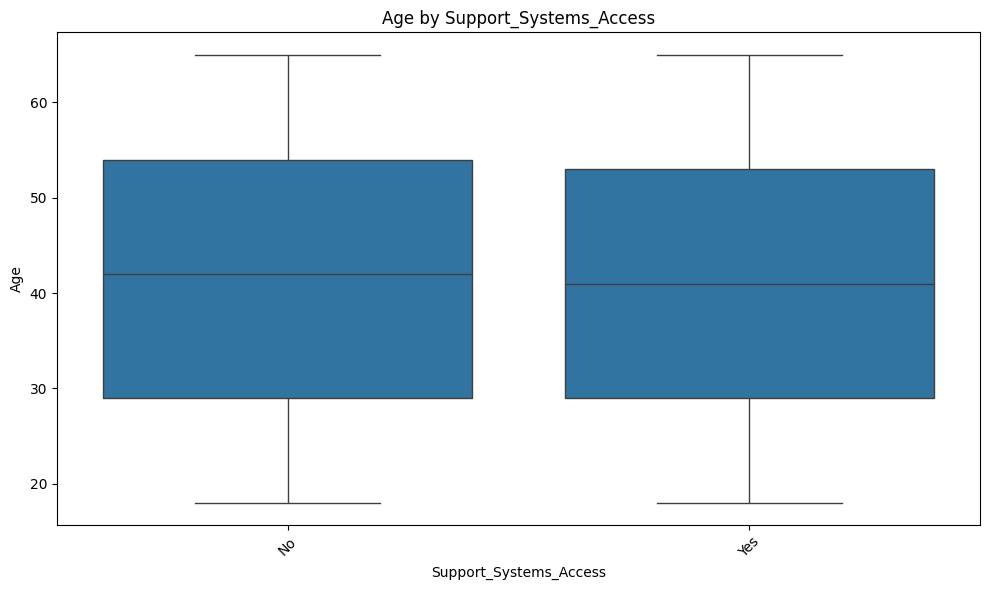

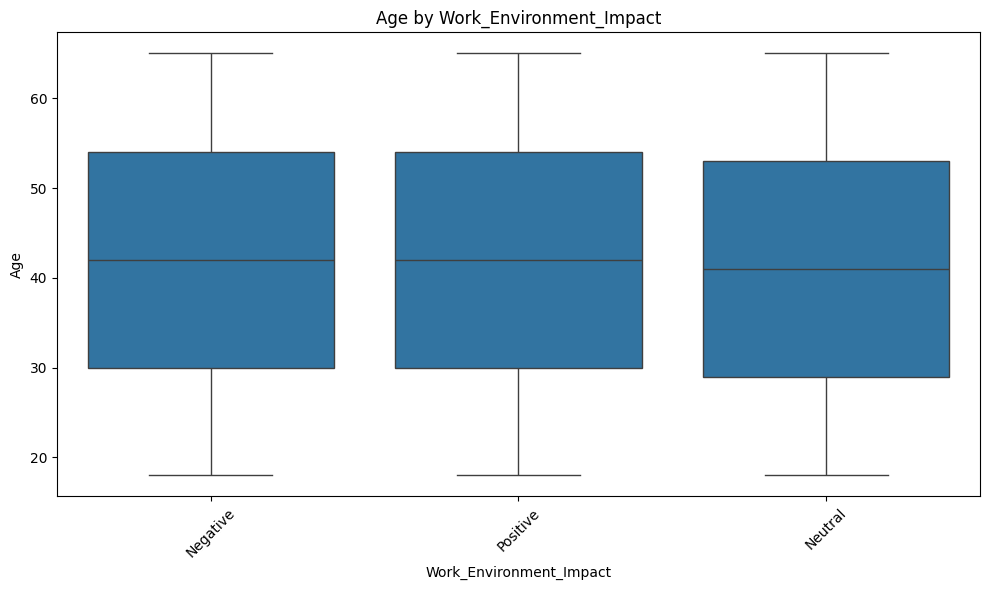

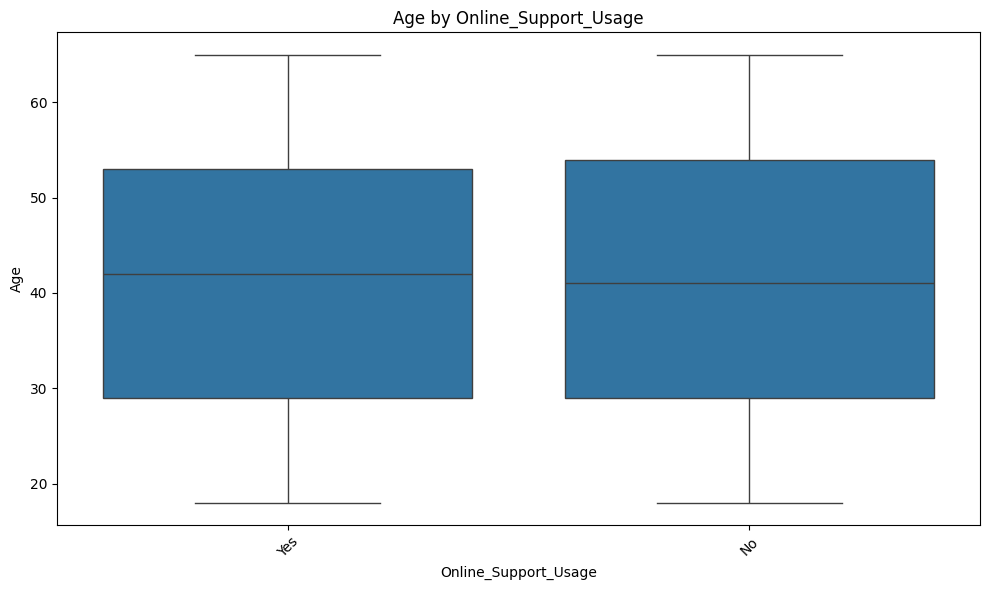

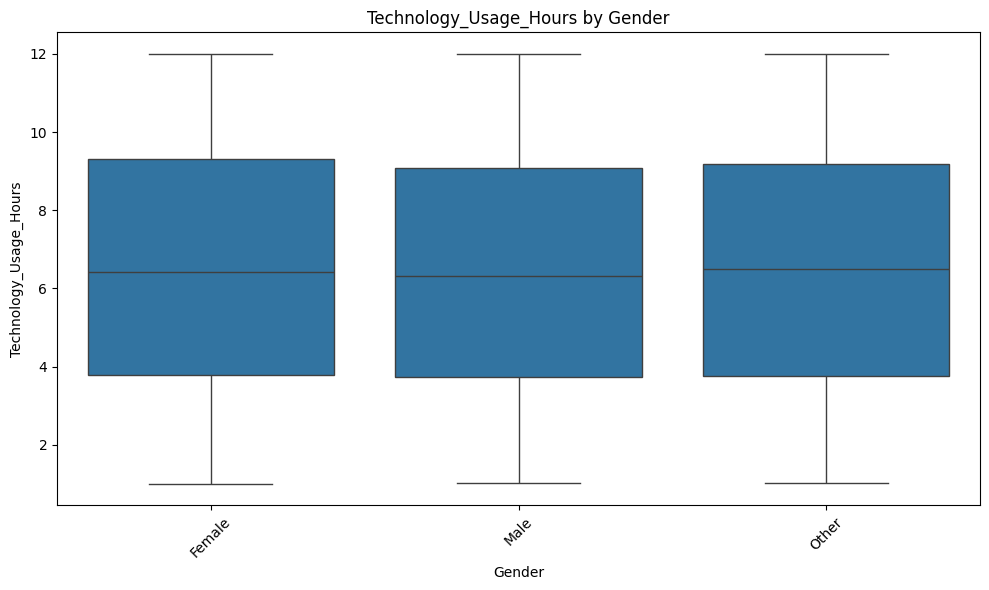

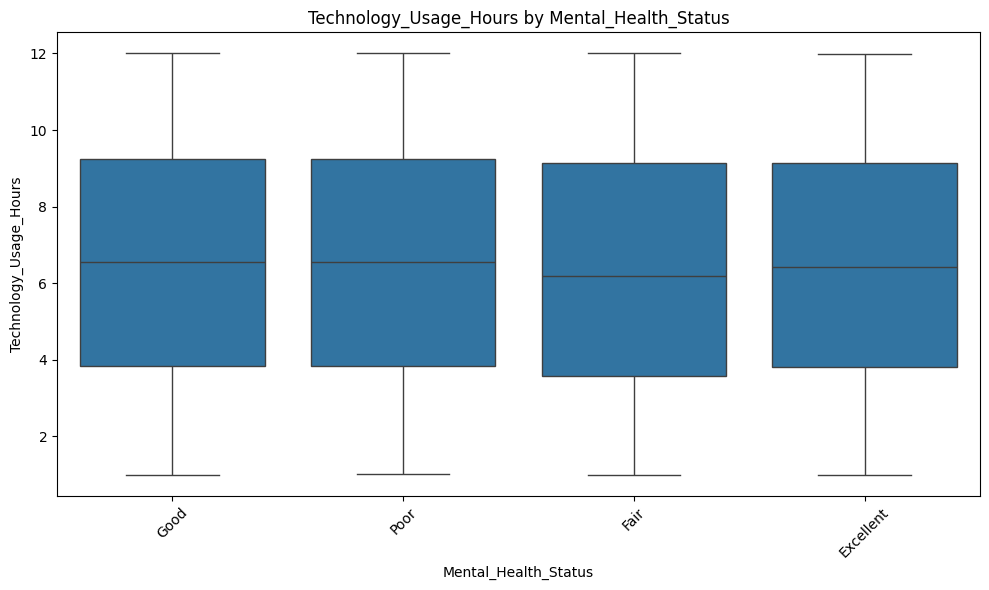

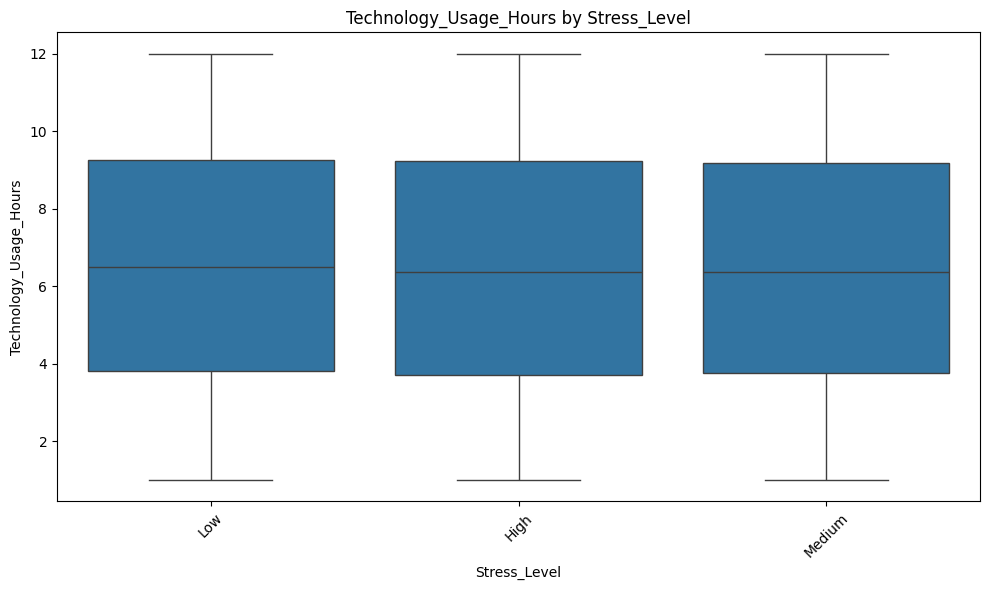

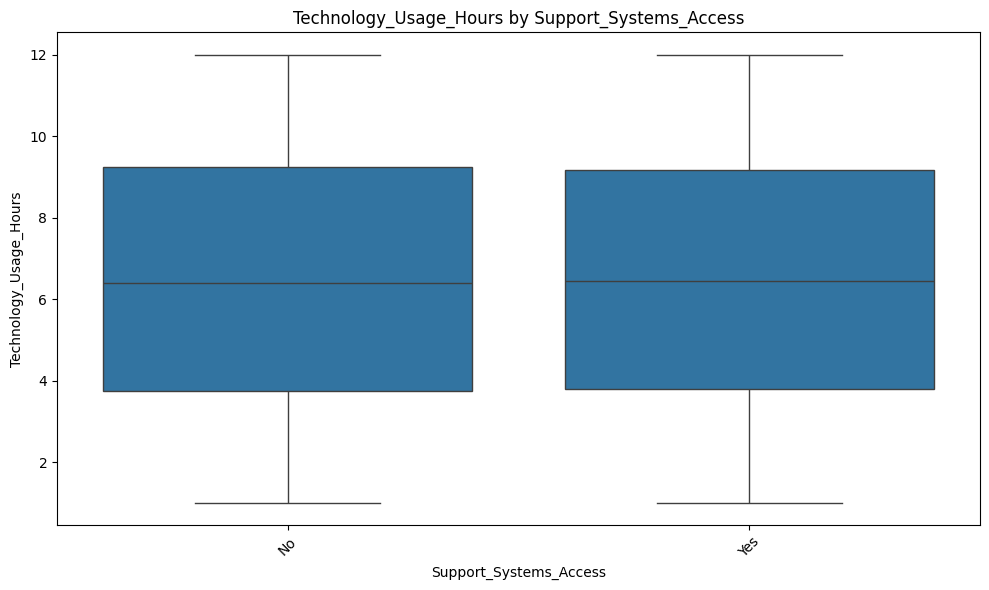

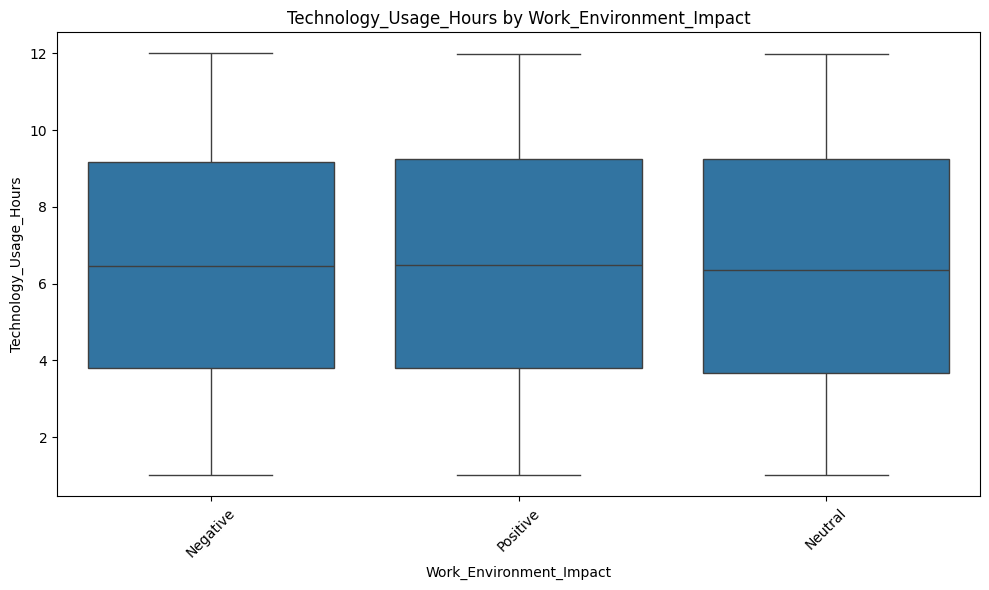

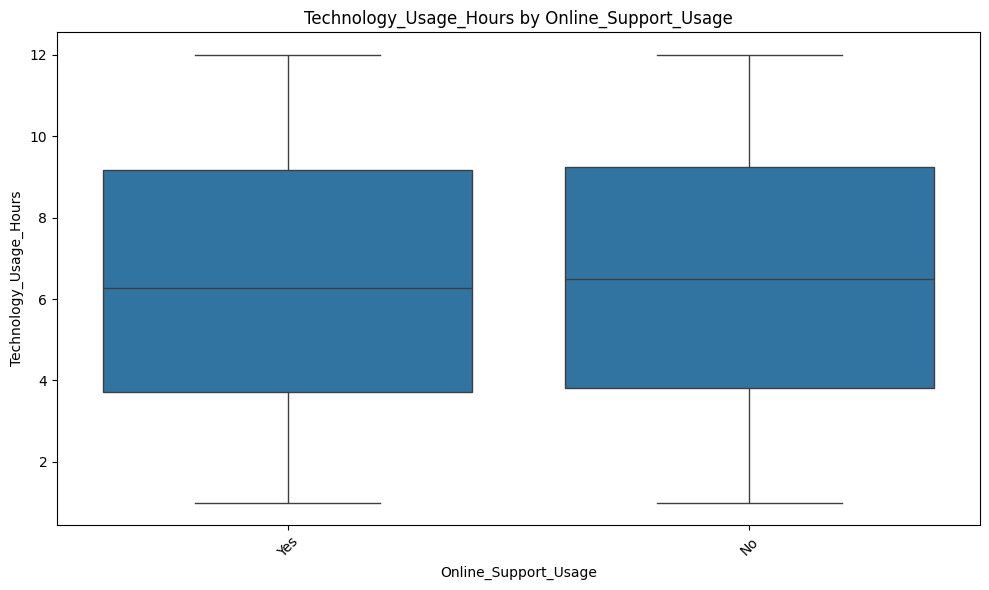

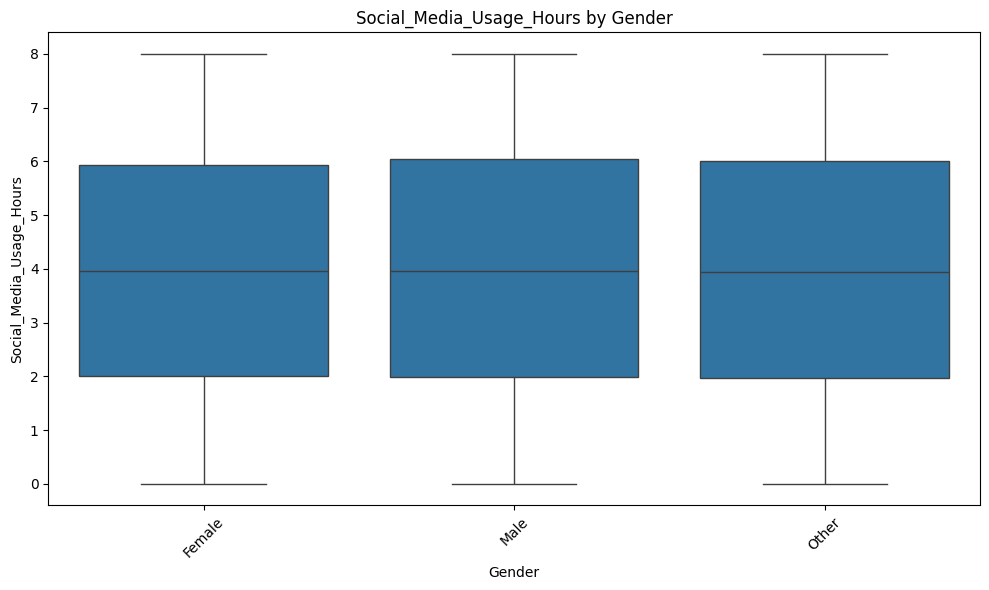

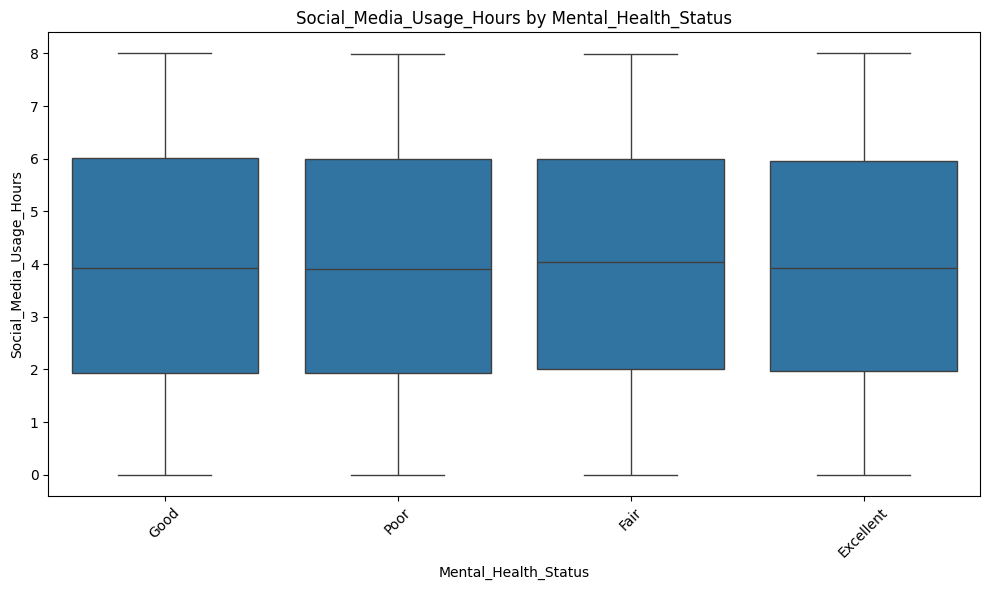

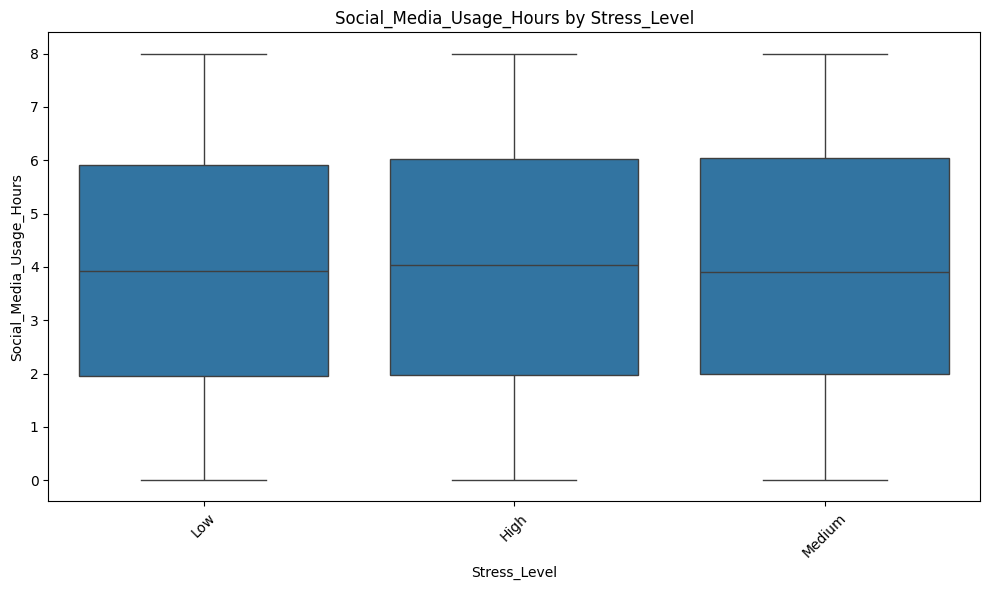

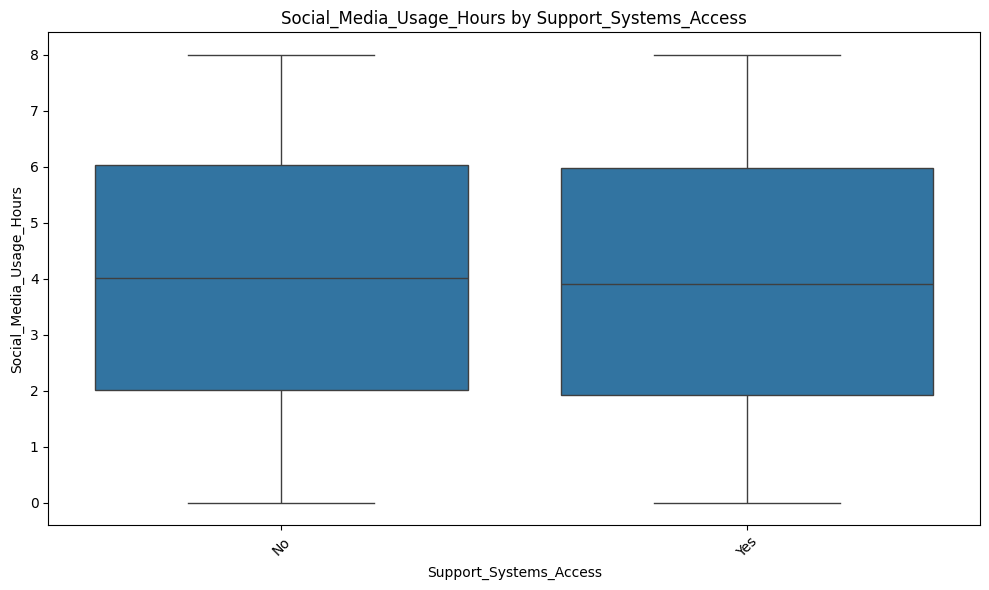

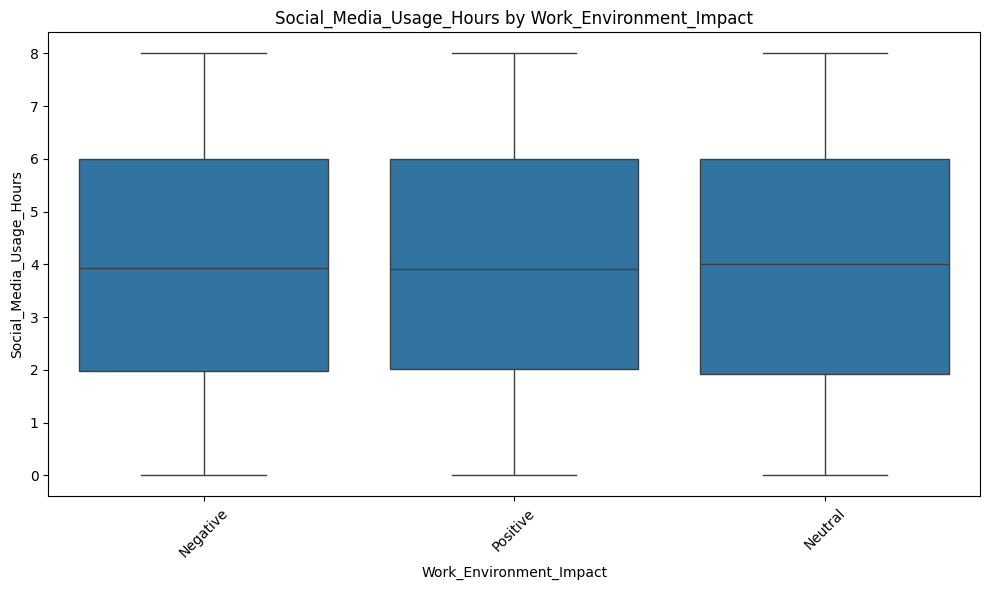

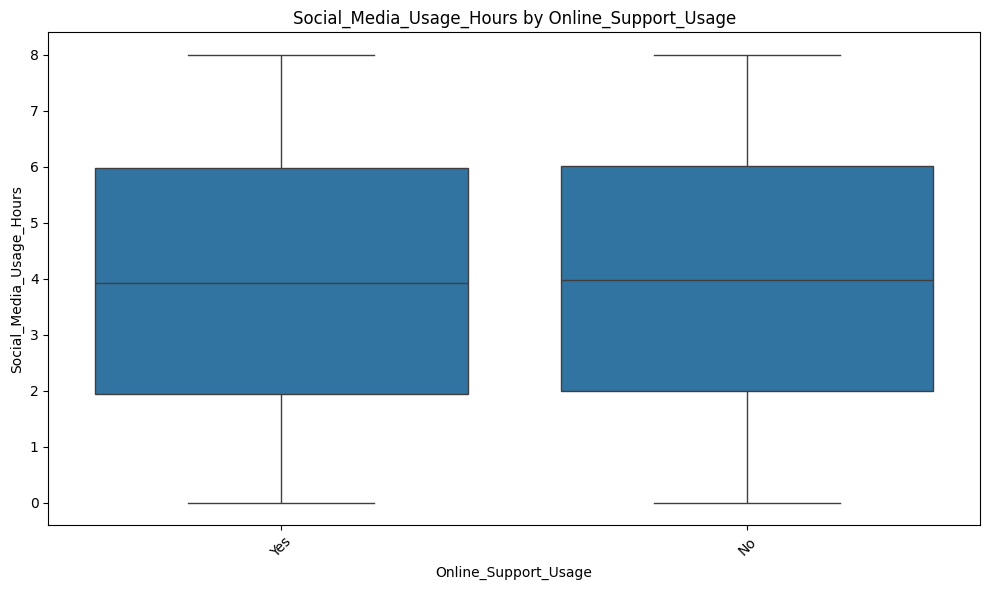

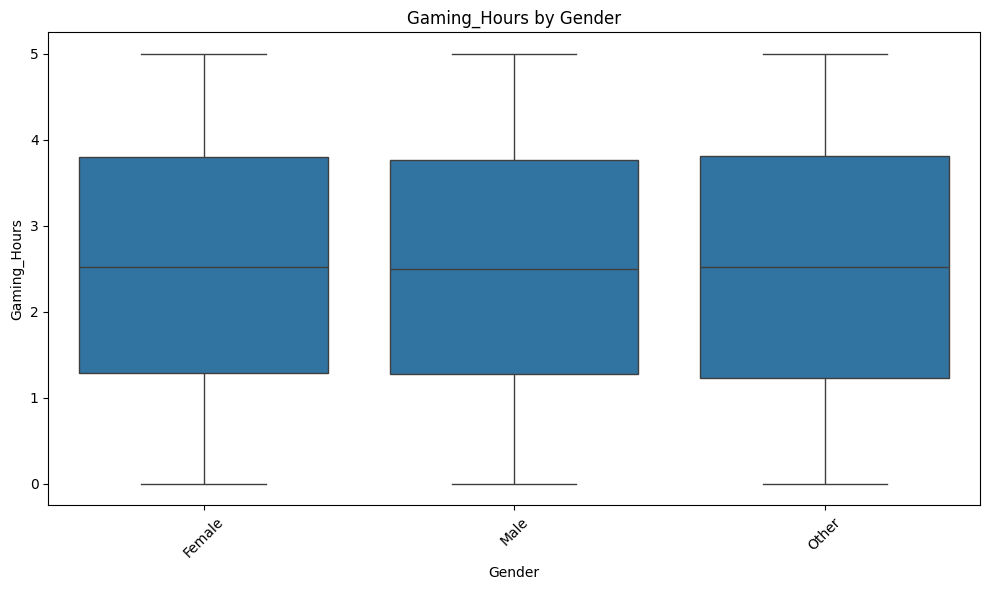

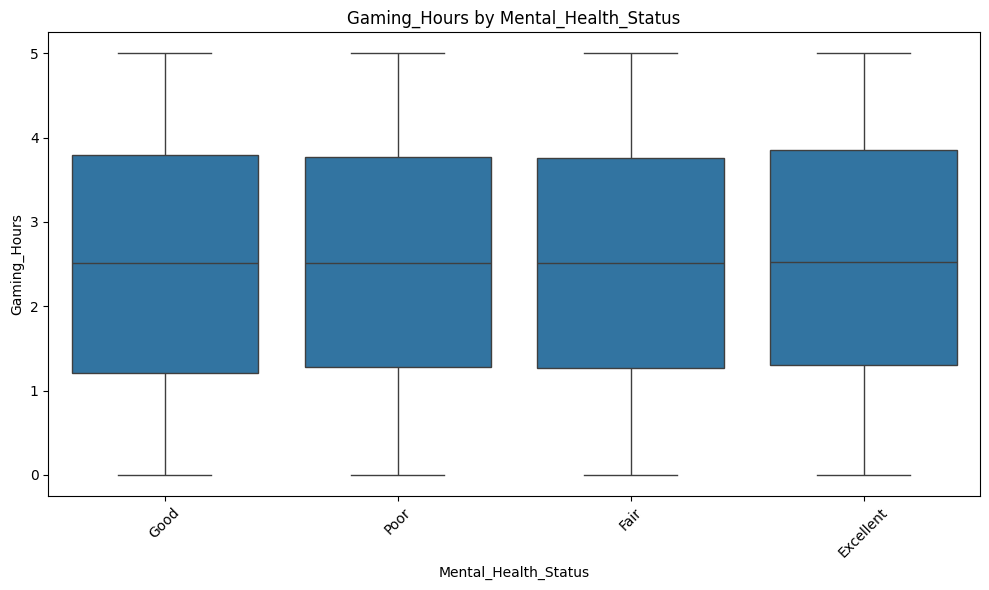

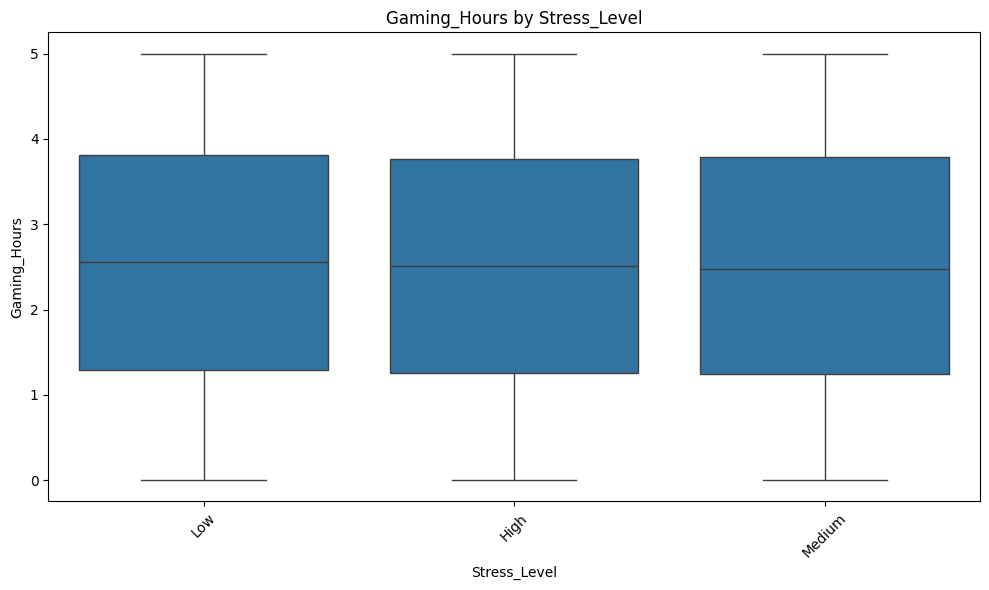

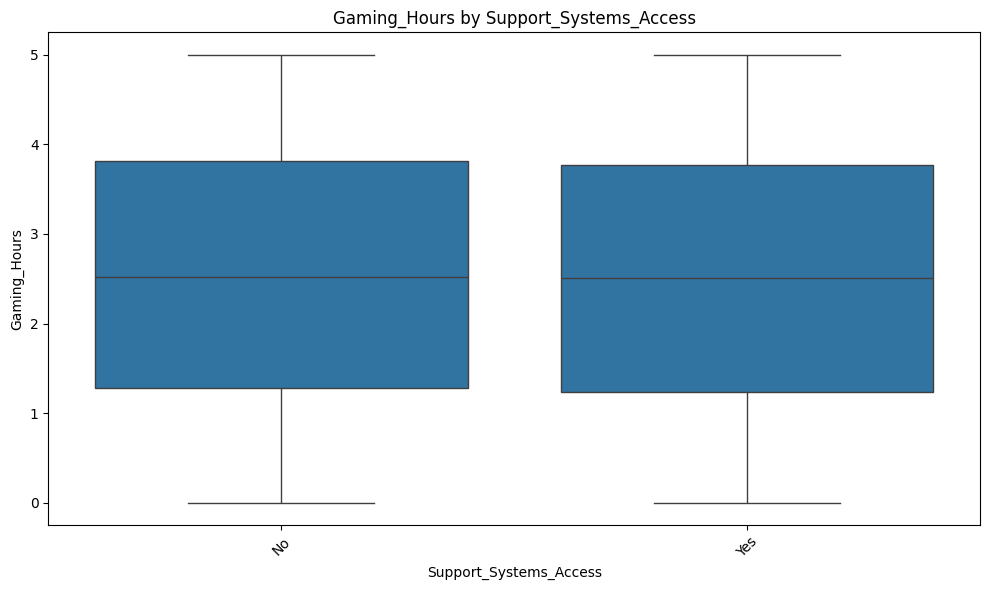

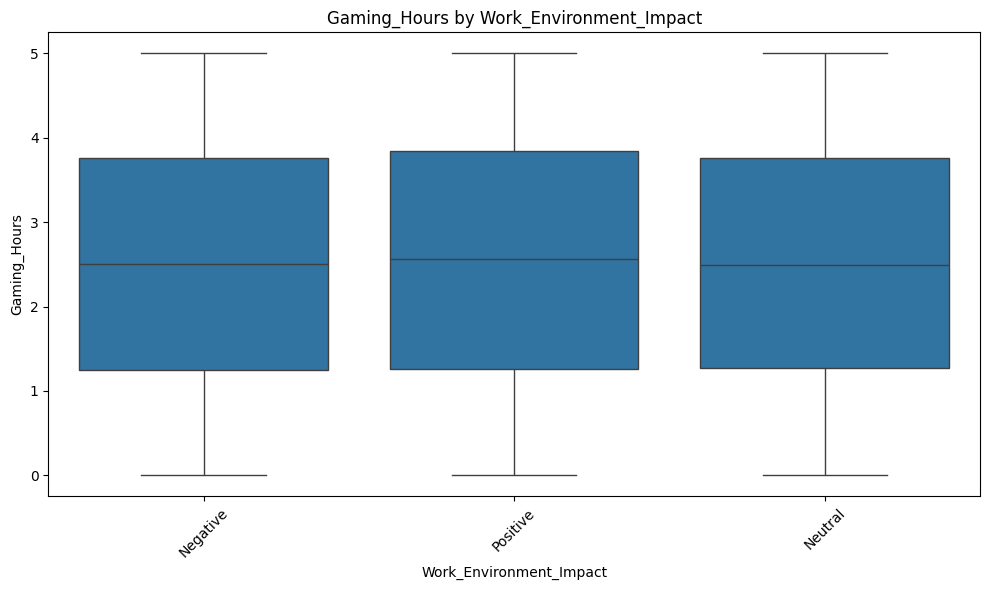

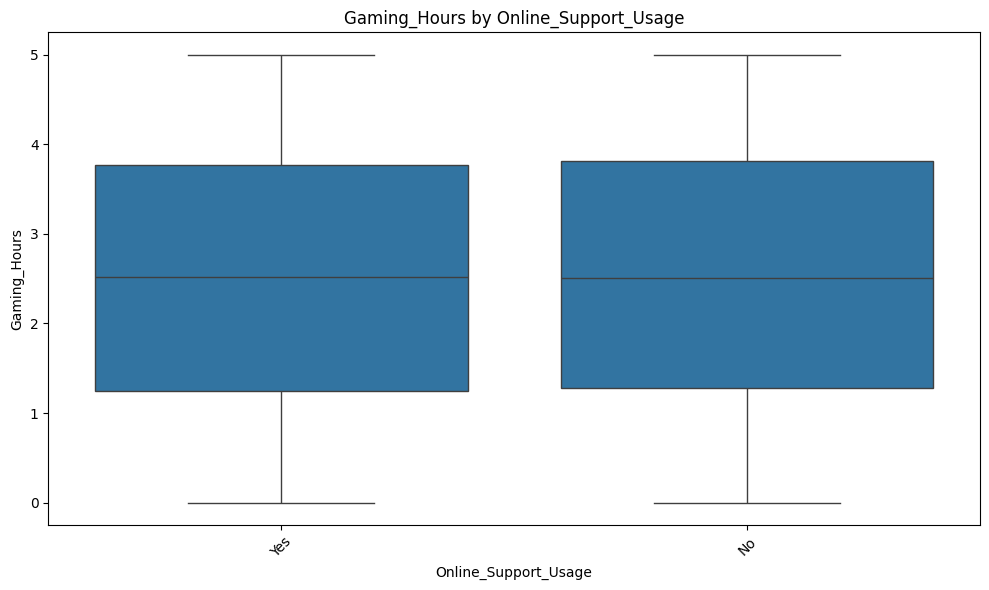

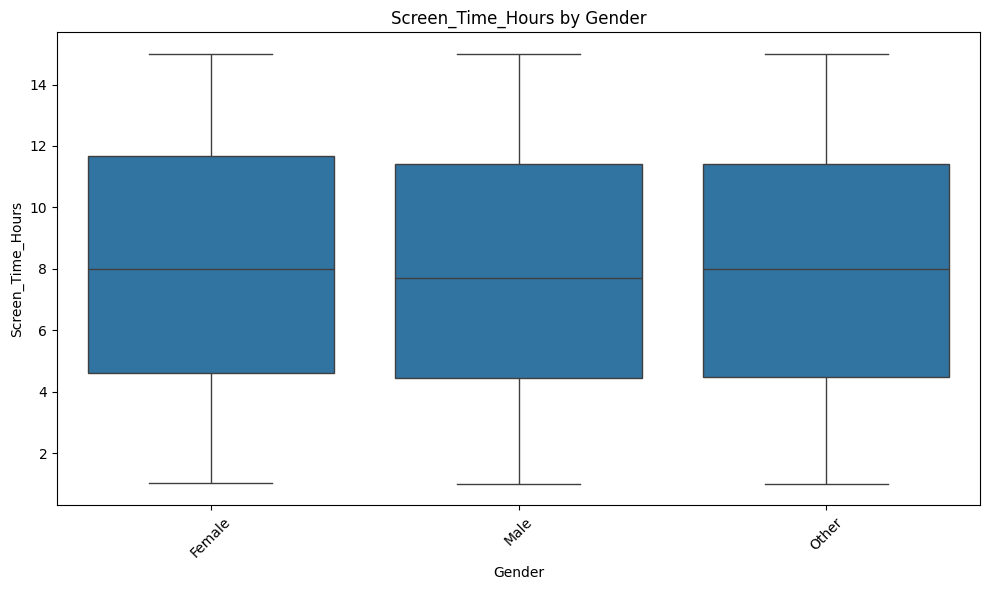

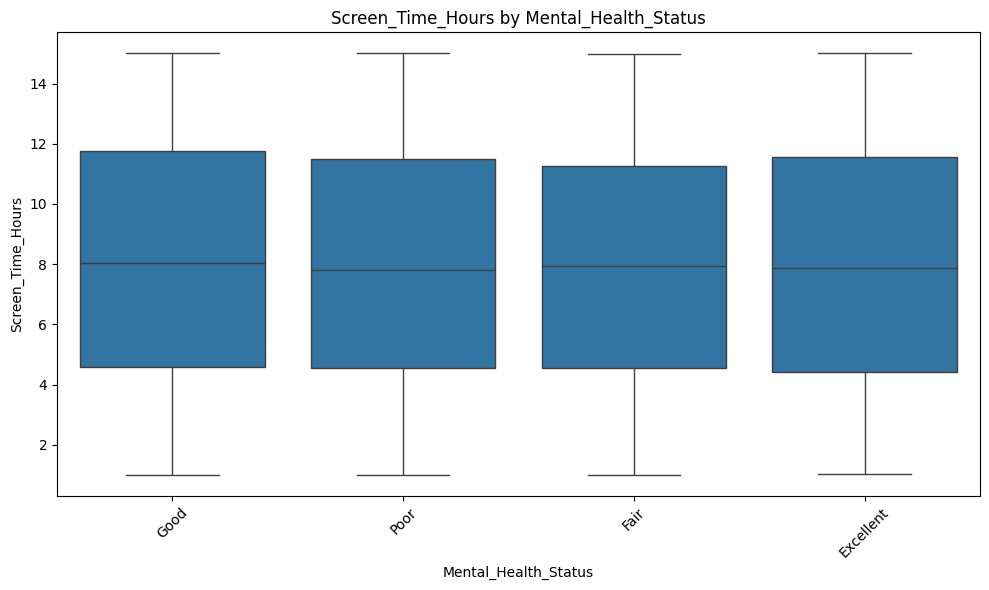

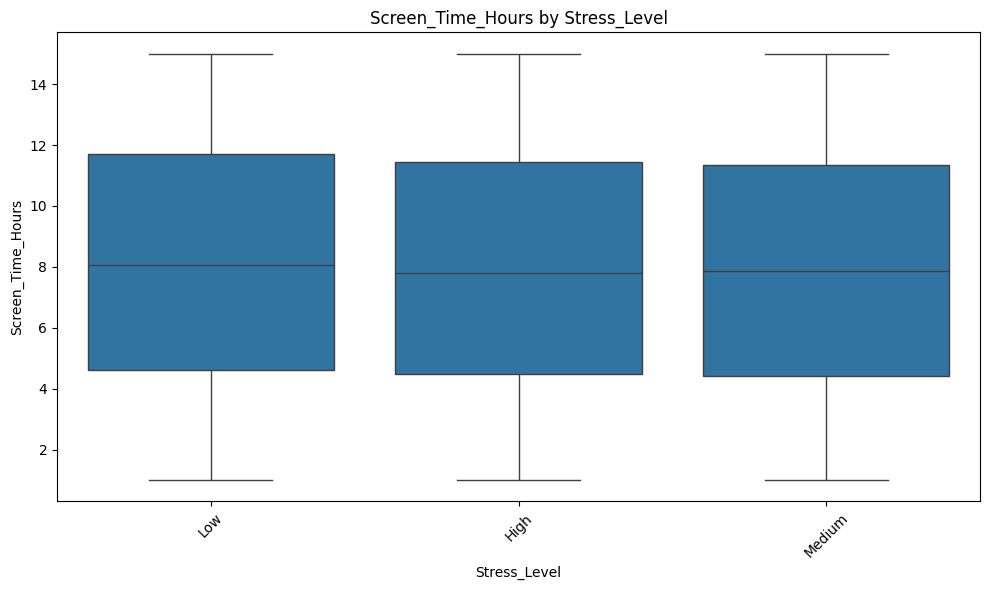

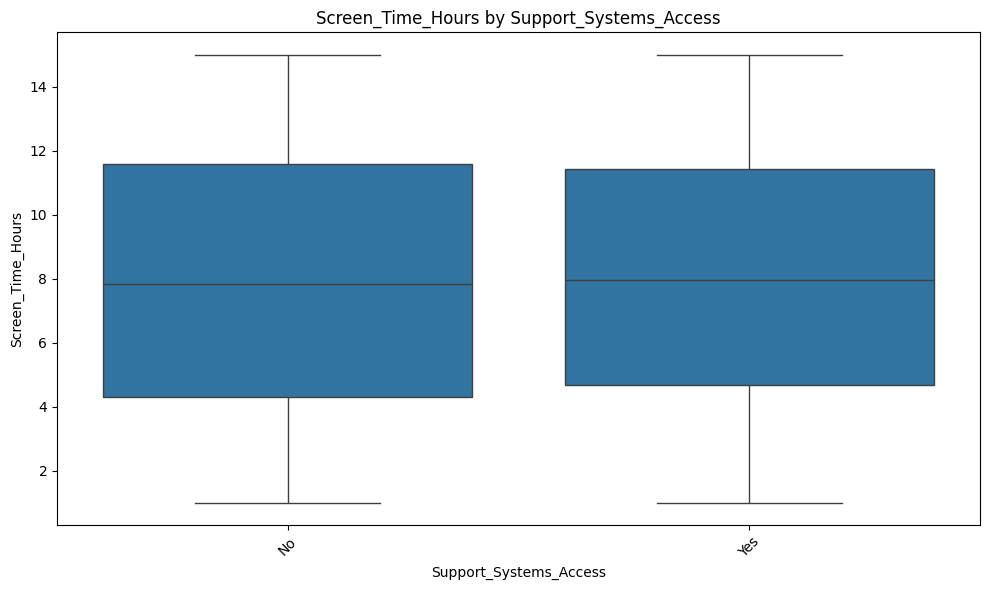

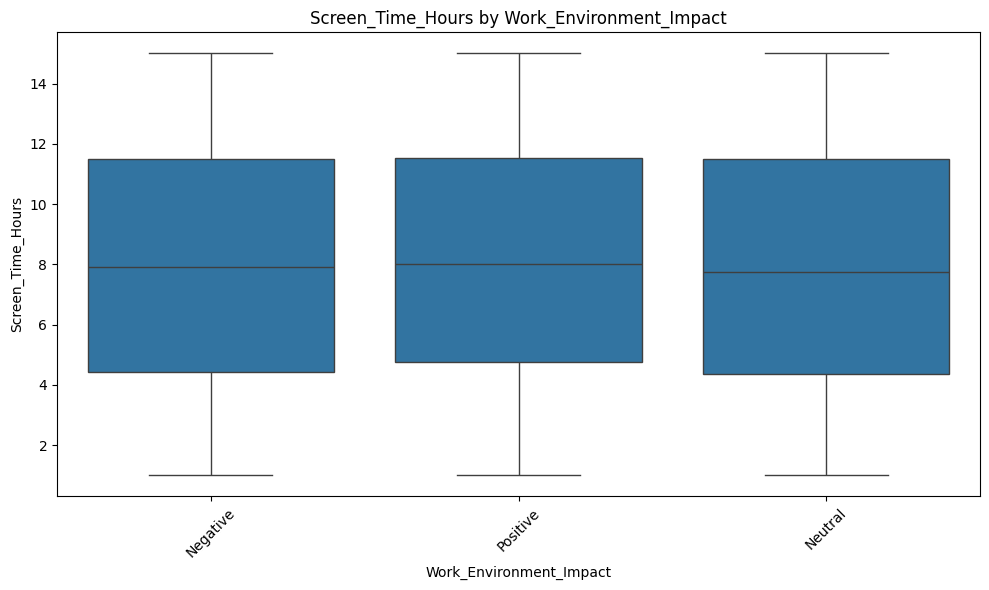

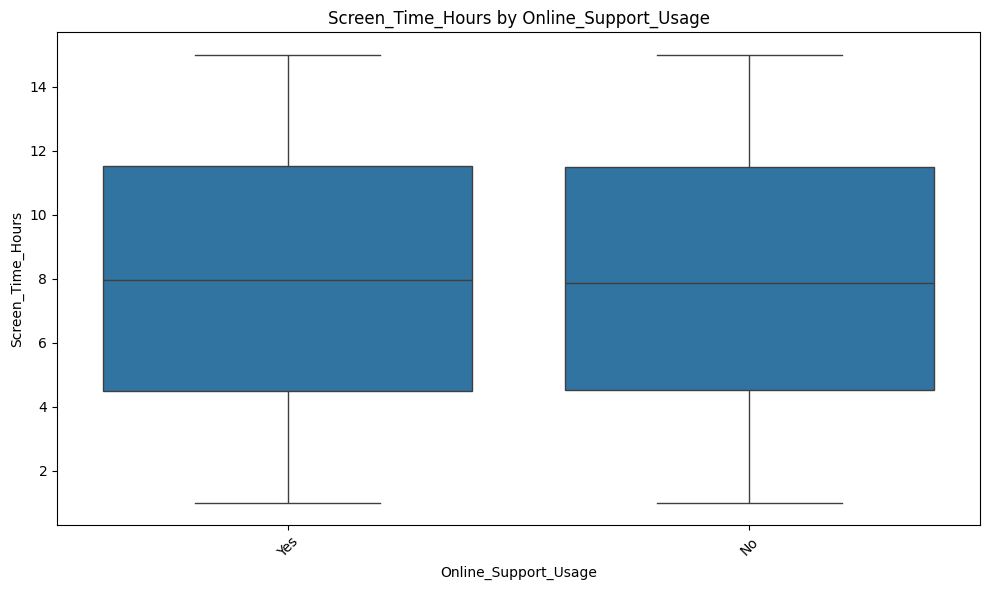

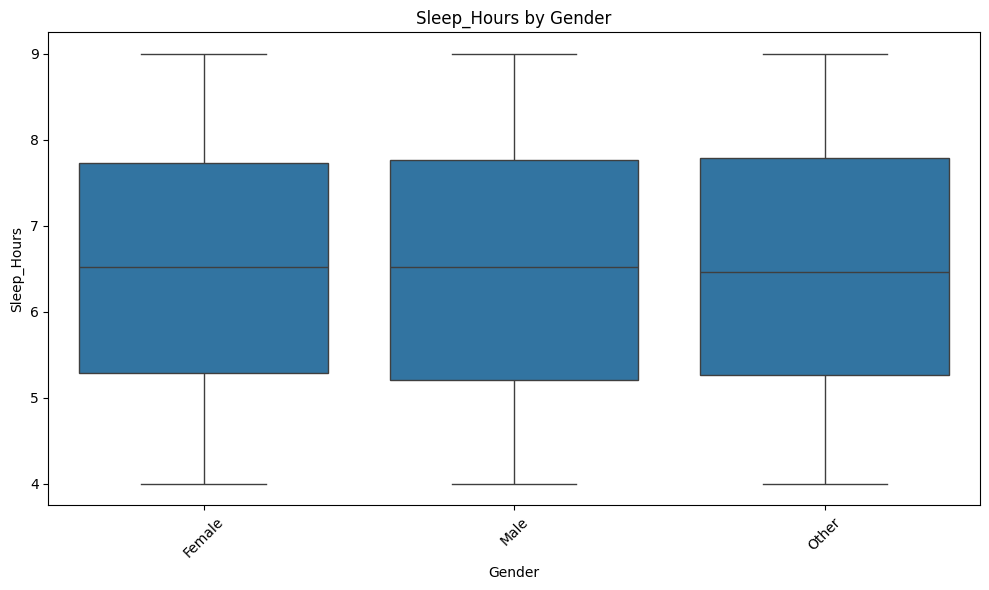

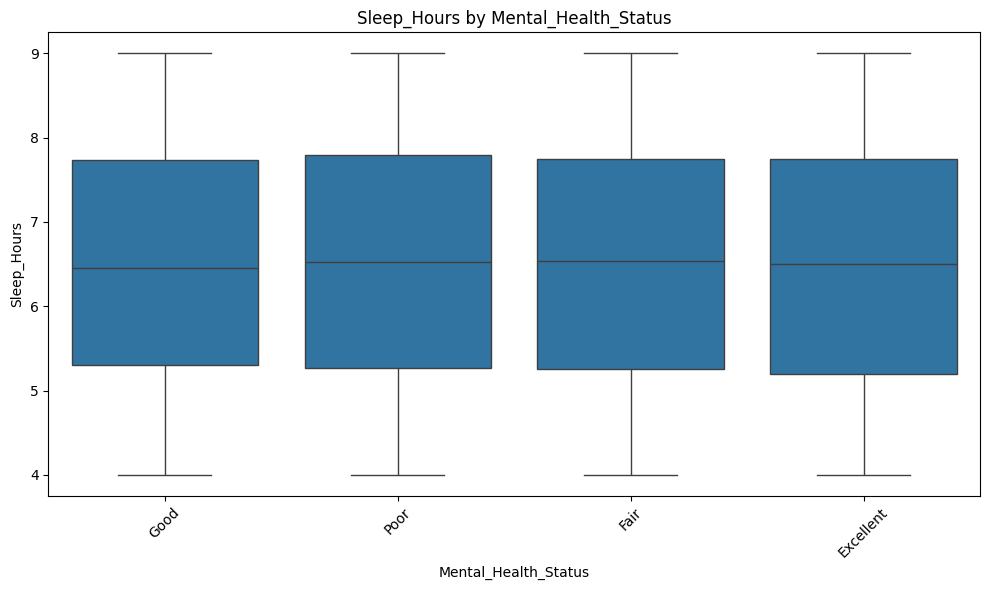

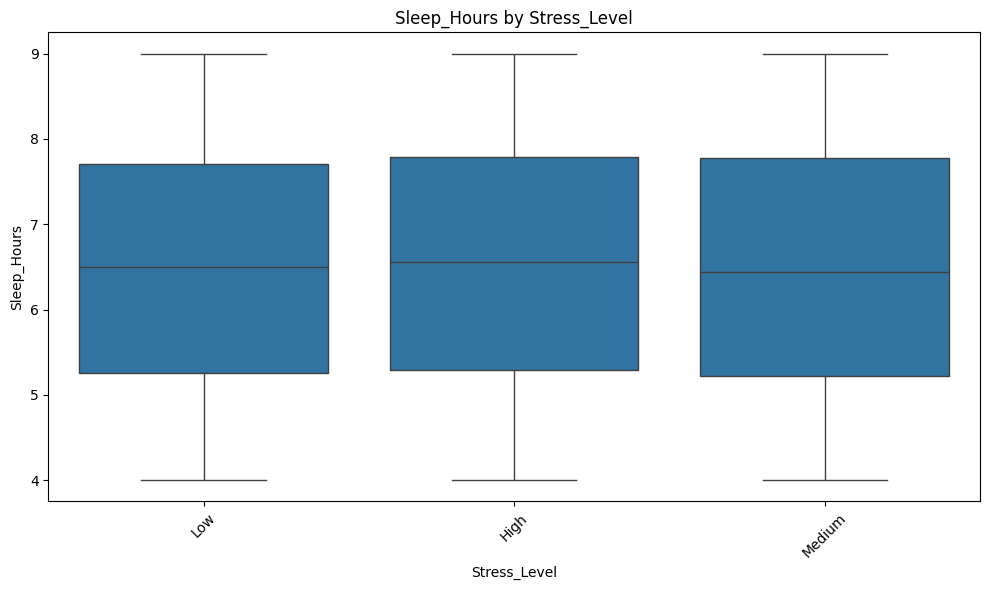

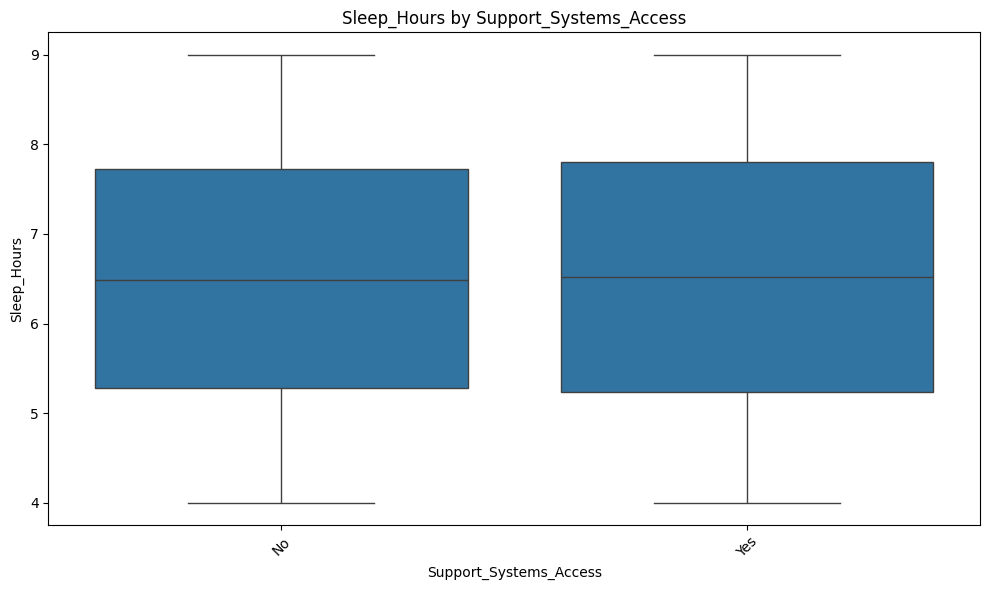

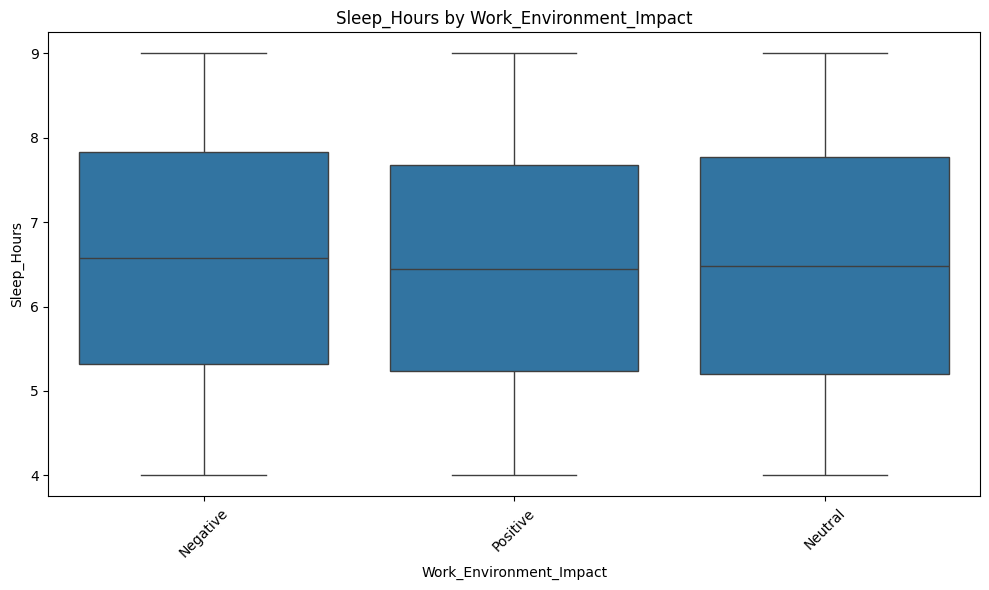

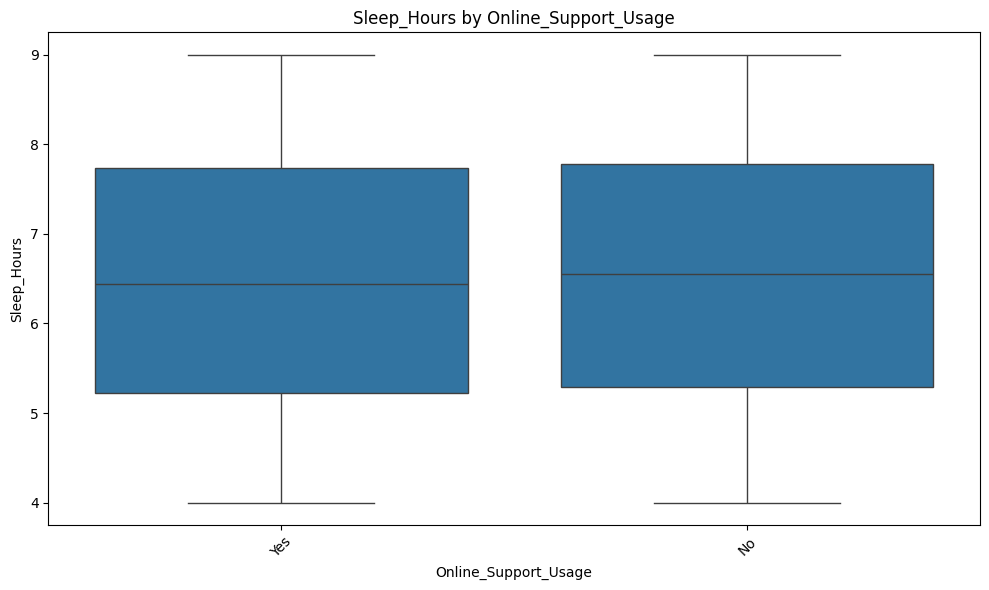

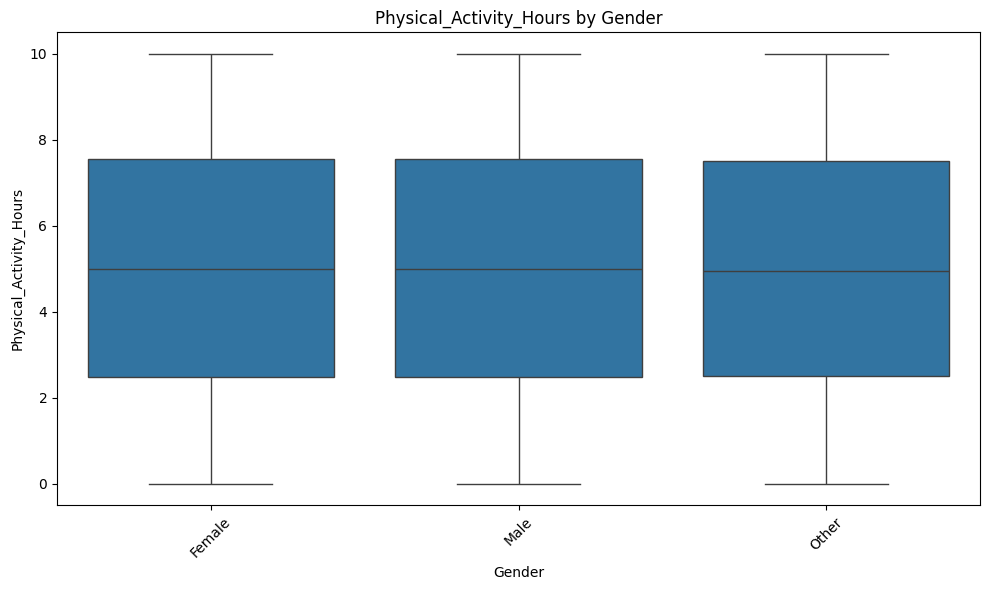

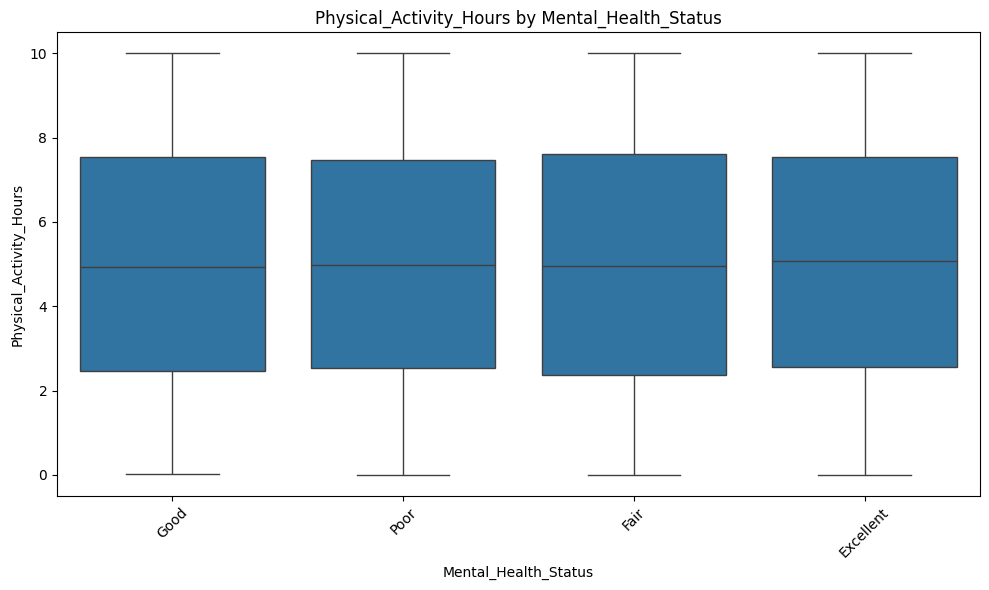

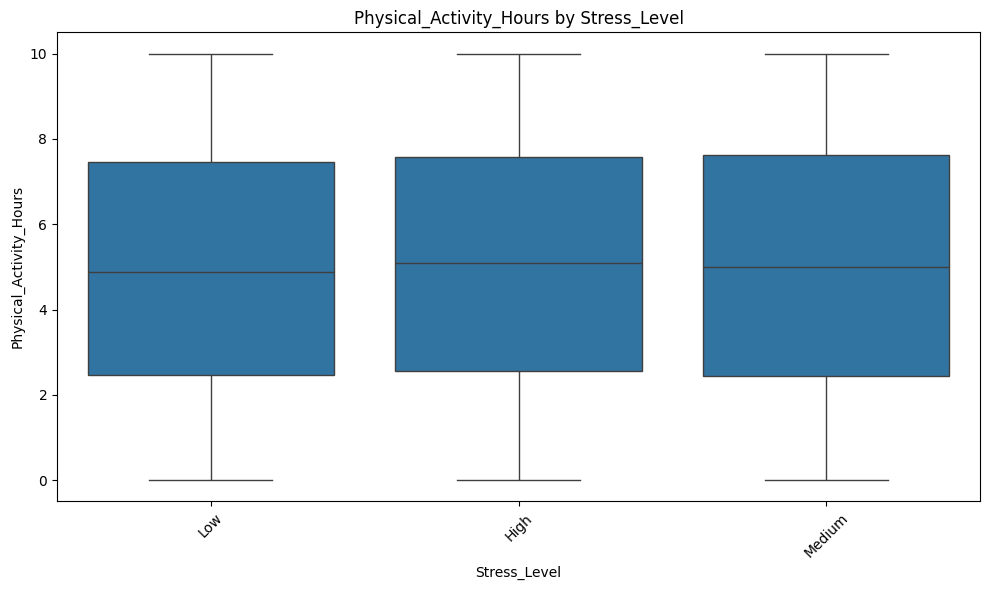

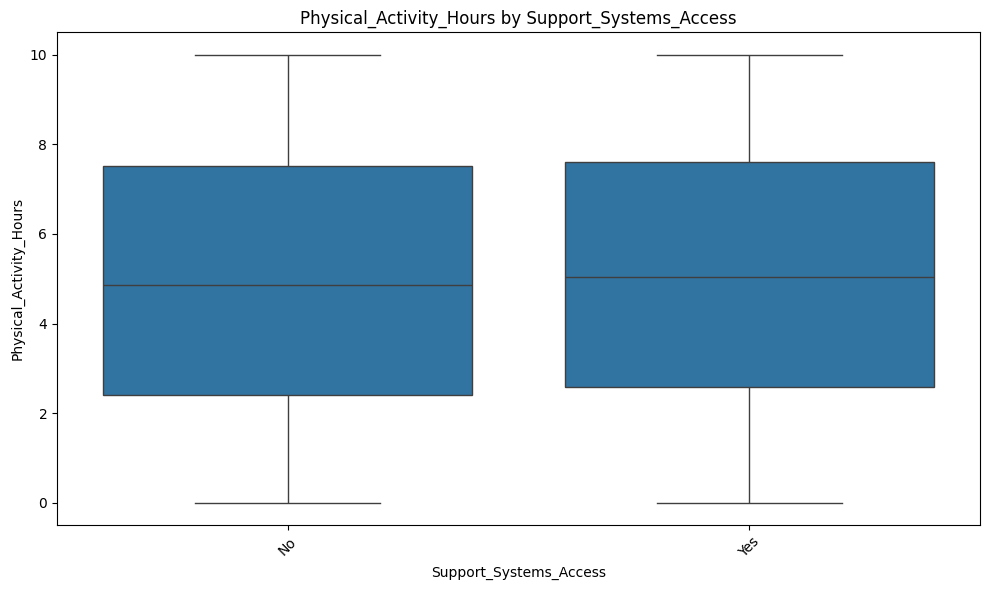

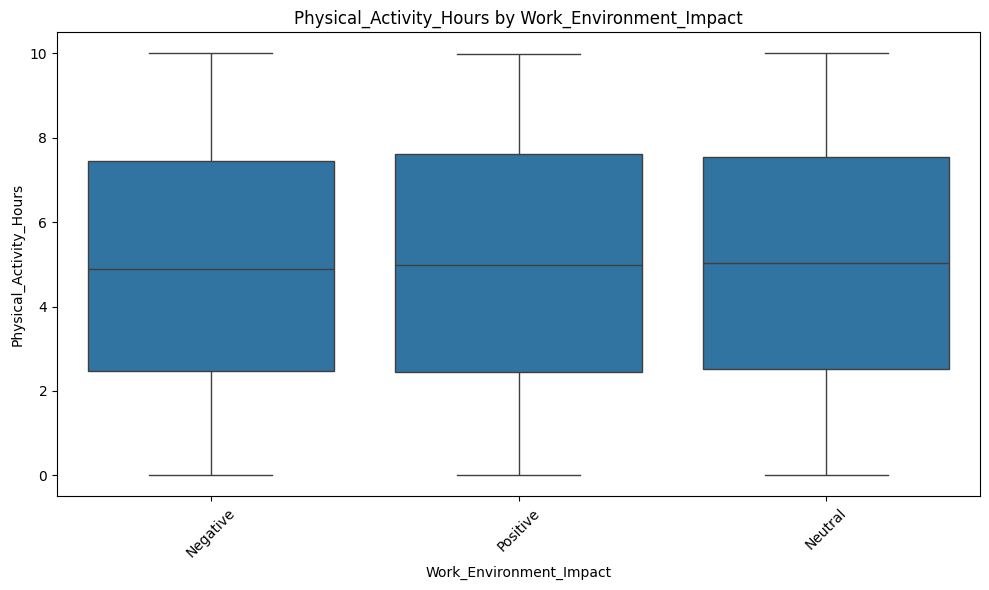

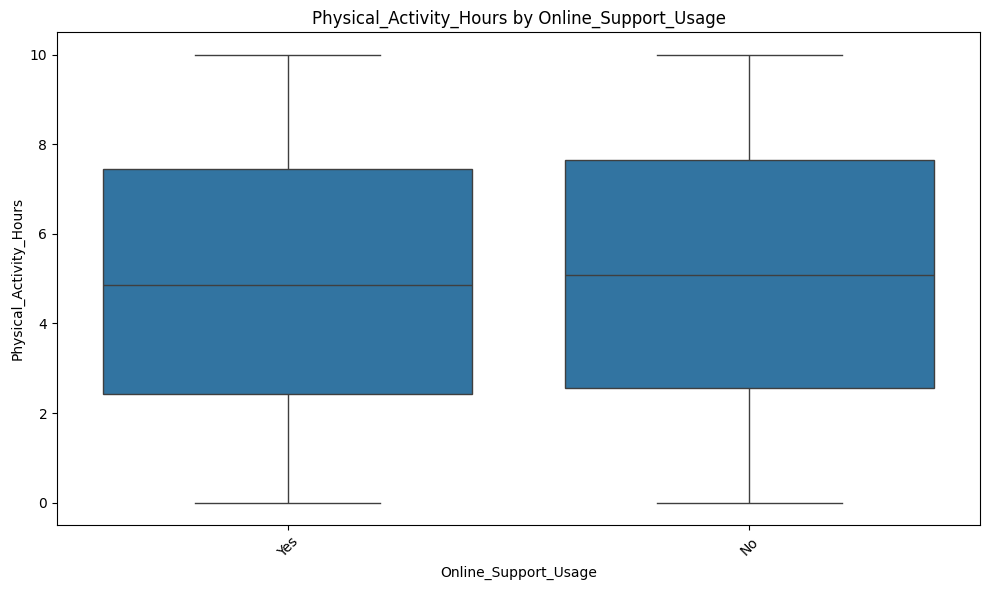

In [21]:
categorical_features = data.select_dtypes(include=['object']).drop('User_ID', axis=1).columns
for num_feature in numeric_features:
    for cat_feature in categorical_features:
        plot_boxplot(data, num_feature, cat_feature)

### Проверка равномерности зависимостей между числовыми и категориальными признаками
- H0: Зависимость между числовым и категориальным признаком равномерна
- H1: Зависимость между числовым и категориальным признаком не равномерна
- Уровень значимости: 0.05

In [22]:
def test_uniformity_numeric_vs_categorical(data, numeric_feature, categorical_feature, p_value=0.05):
    groups = [group for _, group in data.groupby(categorical_feature)[numeric_feature]]
    f_statistic, p = stats.f_oneway(*groups)
    
    df_between = len(groups) - 1
    df_within = sum(len(group) - 1 for group in groups)
    eta_squared = (df_between * f_statistic) / (df_between * f_statistic + df_within)
    effect_size = np.sqrt(eta_squared)
    
    return {
        'numeric_feature': numeric_feature,
        'categorical_feature': categorical_feature,
        'f_statistic': f_statistic,
        'p_value': p,
        'is_uniform': p > p_value,
        'effect_size': effect_size
    }

### Определяем числовые и категориальные признаки


In [23]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

numeric_features = [col for col in numeric_features if col != 'User_ID']
categorical_features = [col for col in categorical_features if col != 'User_ID']

### Проводим тест для всех комбинаций числовых и категориальных признаков


In [24]:
dependency_results = []

for num_feature in numeric_features:
    for cat_feature in categorical_features:
        result = test_uniformity_numeric_vs_categorical(data, num_feature, cat_feature)
        dependency_results.append(result)

# Создаем датафрейм с результатами
dependency_df = pd.DataFrame(dependency_results)
dependency_df

,numeric_feature,categorical_feature,f_statistic,p_value,is_uniform,effect_size
0,Age,Gender,2.243282,0.106163,True,0.021180
1,Age,Mental_Health_Status,1.610324,0.184673,True,0.021979
2,Age,Stress_Level,0.494859,0.609672,True,0.009949
3,Age,Support_Systems_Access,0.034823,0.851971,True,0.001866
4,Age,Work_Environment_Impact,3.943873,0.019403,False,0.028078
5,Age,Online_Support_Usage,0.109437,0.740793,True,0.003308
6,Technology_Usage_Hours,Gender,0.768236,0.463858,True,0.012396
7,Technology_Usage_Hours,Mental_Health_Status,2.415171,0.064536,True,0.026913
8,Technology_Usage_Hours,Stress_Level,0.962224,0.382078,True,0.013873
9,Technology_Usage_Hours,Support_Systems_Access,0.034030,0.853648,True,0.001845


### Визуализация результатов теста для числовых и категориальных признаков

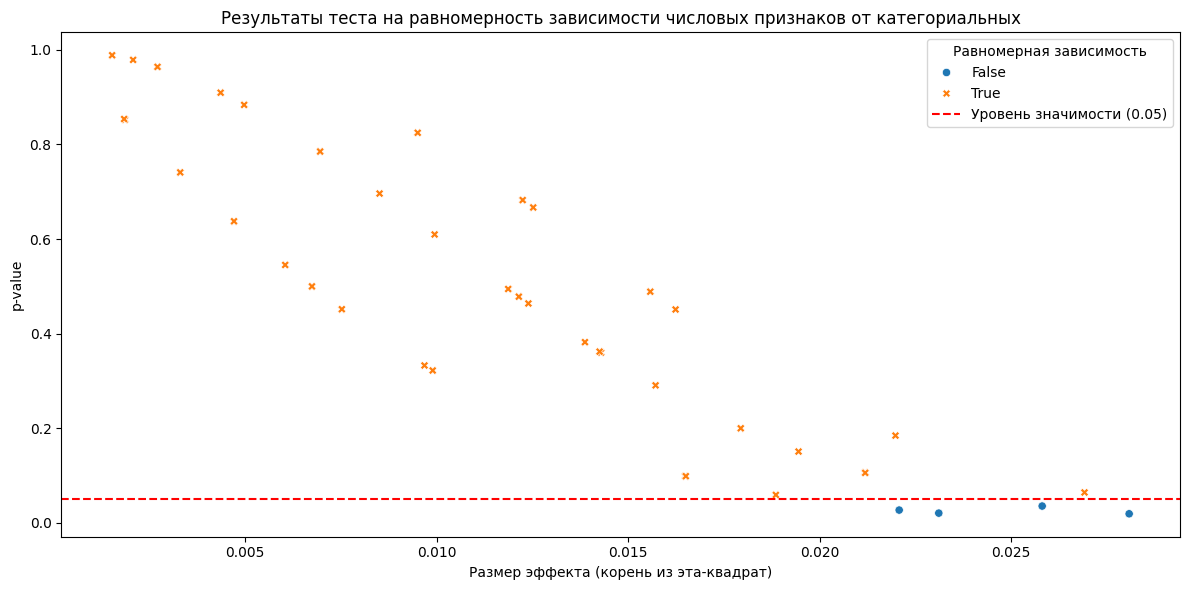

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=dependency_df, x='effect_size', y='p_value', hue='is_uniform', style='is_uniform')
plt.title('Результаты теста на равномерность зависимости числовых признаков от категориальных')
plt.xlabel('Размер эффекта (корень из эта-квадрат)')
plt.ylabel('p-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Уровень значимости (0.05)')
plt.legend(title='Равномерная зависимость')
plt.tight_layout()
plt.show()

### Функция для визуализации зависимости


In [26]:
def plot_dependency(data, numeric_feature, categorical_feature):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_feature, y=numeric_feature, data=data)
    plt.title(f'Зависимость {numeric_feature} от {categorical_feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Визуализация наиболее значимых зависимостей


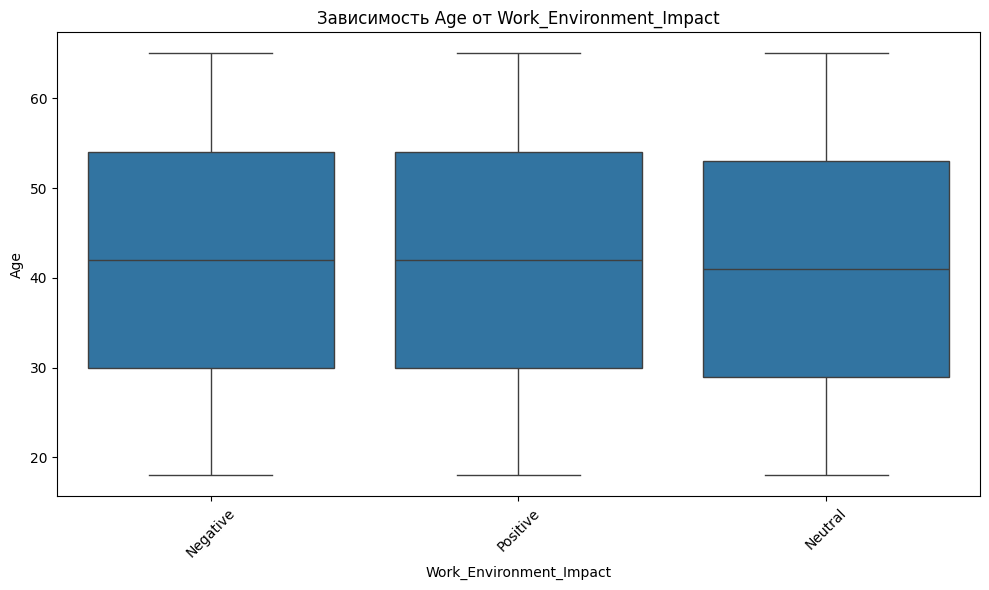

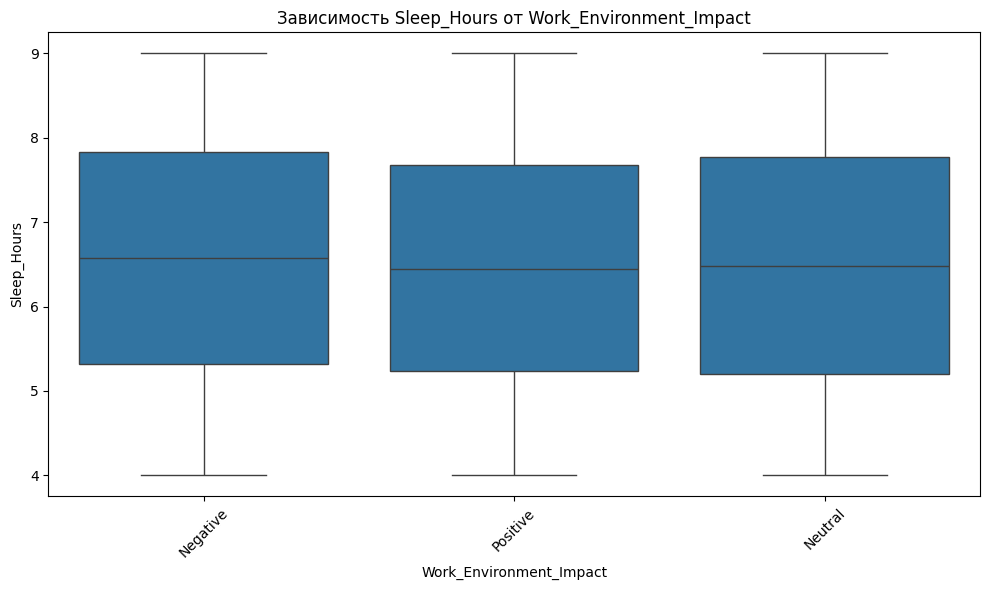

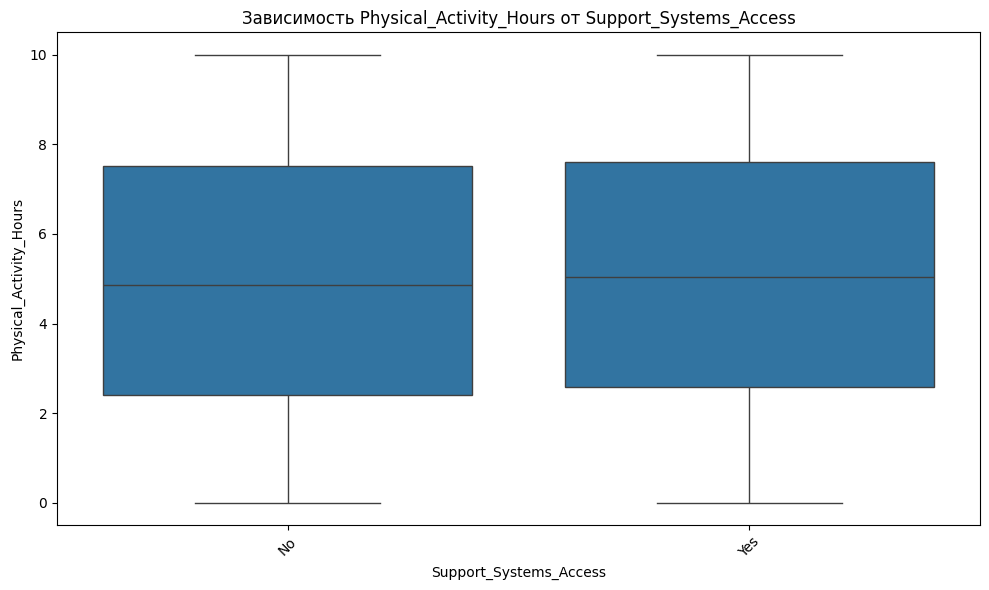

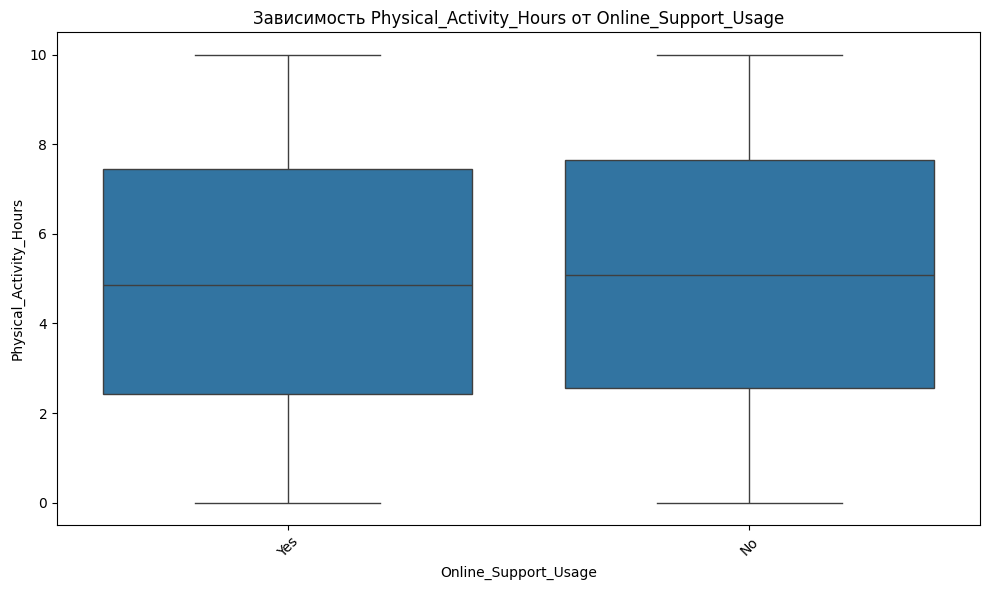

In [27]:
top_dependencies = dependency_df[dependency_df['is_uniform'] == False].head(5)
for _, row in top_dependencies.iterrows():
    plot_dependency(data, row['numeric_feature'], row['categorical_feature'])

### Сравнение результатов с предыдущим анализом


In [28]:
for feature in results_df['feature']:
    if feature in numeric_features:
        prev_result = results_df[results_df['feature'] == feature]['is_uniform'].values[0]
        curr_results = dependency_df[dependency_df['numeric_feature'] == feature]['is_uniform'].values
        
        if prev_result != all(curr_results):
            print(f"Несоответствие для признака {feature}:")
            print(f"  Предыдущий результат: {'равномерное' if prev_result else 'неравномерное'} распределение")
            print(f"  Текущий результат: {'все' if all(curr_results) else 'не все'} зависимости равномерны")


Несоответствие для признака Gaming_Hours:
  Предыдущий результат: неравномерное распределение
  Текущий результат: все зависимости равномерны
Несоответствие для признака Sleep_Hours:
  Предыдущий результат: равномерное распределение
  Текущий результат: не все зависимости равномерны
Несоответствие для признака Physical_Activity_Hours:
  Предыдущий результат: равномерное распределение
  Текущий результат: не все зависимости равномерны


### Анализ влияния категориальных признаков


In [29]:
category_impact = dependency_df.groupby('categorical_feature').agg({
    'is_uniform': lambda x: (~x).mean(),
    'effect_size': 'mean'
}).sort_values('is_uniform', ascending=False)

category_impact

,is_uniform,effect_size
categorical_feature,,
Work_Environment_Impact,0.285714,0.015220
Online_Support_Usage,0.142857,0.011436
Support_Systems_Access,0.142857,0.009804
Gender,0.000000,0.010045
Mental_Health_Status,0.000000,0.016427
Stress_Level,0.000000,0.013205


### Визуализация влияния категориальных признаков


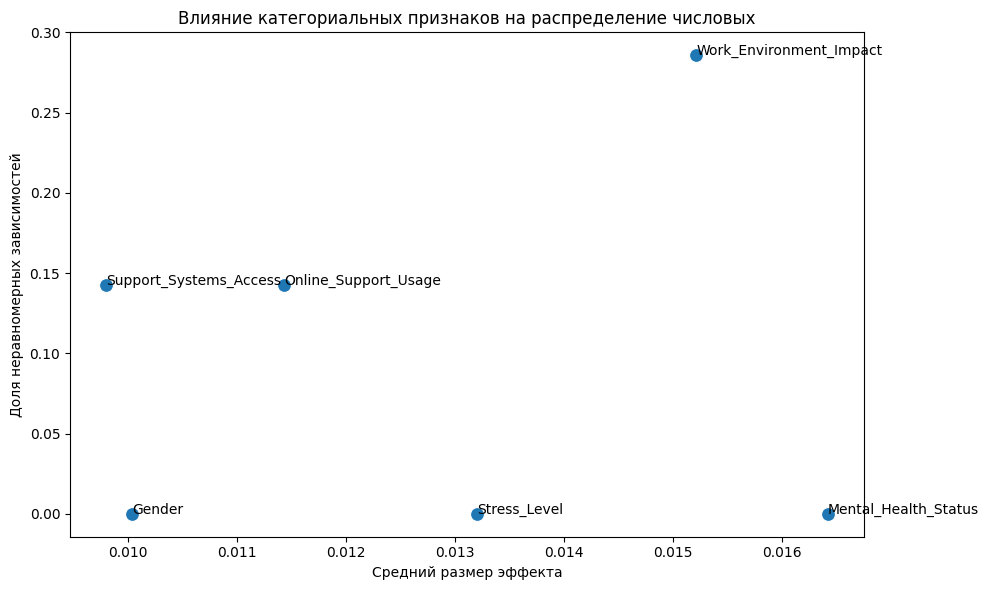

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=category_impact.reset_index(), x='effect_size', y='is_uniform', s=100)
for i, row in category_impact.reset_index().iterrows():
    plt.annotate(row['categorical_feature'], (row['effect_size'], row['is_uniform']))
plt.title('Влияние категориальных признаков на распределение числовых')
plt.xlabel('Средний размер эффекта')
plt.ylabel('Доля неравномерных зависимостей')  
plt.tight_layout()  
plt.show() 

# Выводы по Анализу данных

## Визуализация распределения признаков:
* Создана функция `plot_distribution` для визуализации распределения каждого признака.
* Построены гистограммы для числовых признаков и столбчатые диаграммы для категориальных.
* Визуализация позволила быстро оценить характер распределения каждого признака.

## Корреляционный анализ:
* Построена тепловая карта корреляций для числовых признаков.
* Использована библиотека seaborn для наглядного представления корреляционной матрицы.
* Анализ позволил выявить наиболее сильные линейные связи между признаками.

## Тест на равномерность распределения:
* Разработана функция `test_uniformity` для проведения теста хи-квадрат.
* Проведен тест для всех признаков с уровнем значимости 0.05.
* Результаты теста визуализированы с помощью scatter plot, где показаны статистика хи-квадрат и p-value для каждого признака.
* Выявлены признаки с неравномерным распределением.

## Анализ зависимостей между числовыми и категориальными признаками:
* Создана функция `plot_boxplot` для визуализации зависимостей.
* Построены box plot'ы для всех комбинаций числовых и категориальных признаков.
* Разработана функция `test_uniformity_numeric_vs_categorical` для проведения однофакторного дисперсионного анализа (ANOVA).
* Проведен тест для всех комбинаций числовых и категориальных признаков.
* Результаты визуализированы с помощью scatter plot, показывающего размер эффекта и p-value для каждой комбинации.

## Сравнение результатов с предыдущим анализом:
* Проведено сравнение результатов теста на равномерность распределения с результатами анализа зависимостей.
* Выявлены несоответствия в результатах для некоторых признаков.

## Анализ влияния категориальных признаков:
* Рассчитана доля неравномерных зависимостей для каждого категориального признака.
* Вычислен средний размер эффекта для каждого категориального признака.
* Результаты визуализированы с помощью scatter plot, показывающего влияние каждого категориального признака на распределение числовых.

## Выводы:
* Выявлены признаки с наиболее неравномерным распределением.
* Обнаружены значимые зависимости между некоторыми числовыми и категориальными признаками.
* Определены категориальные признаки, оказывающие наибольшее влияние на распределение числовых (например, "Work_Environment_Impact").



# Обучение модели

### Обучение Логистической регрессии

In [44]:
def train_and_evaluate_model(X, y, model, param_grid, model_name):
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Определение числовых и категориальных признаков
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание препроцессора
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])

    # Создание пайплайна
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Настройка GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

    # Обучение модели с GridSearch
    grid_search.fit(X_train, y_train)

    # Вывод лучших параметров и оценки
    print(f"\n{model_name} - Лучшие параметры:", grid_search.best_params_)
    print(f"{model_name} - Лучшая оценка F1:", grid_search.best_score_)

    # Получение лучшей модели
    best_model = grid_search.best_estimator_

    # Предсказания на тестовом наборе
    y_pred = best_model.predict(X_test)

    # Расчет метрик на тестовом наборе
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Вывод метрик
    print(f"\n{model_name} - Метрики на тестовом наборе:")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    return best_model

# Подготовка данных
X = data.drop(['Mental_Health_Status', 'User_ID'], axis=1)
y = data['Mental_Health_Status']

# Логистическая регрессия
log_reg_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [1000, 2000, 3000]
}

best_log_reg = train_and_evaluate_model(
    X, y, 
    LogisticRegression(random_state=42), 
    log_reg_params, 
    "Логистическая регрессия"
)


Логистическая регрессия - Лучшие параметры: {'classifier__C': 0.001, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Логистическая регрессия - Лучшая оценка F1: 0.2518049903083831

Логистическая регрессия - Метрики на тестовом наборе:
F1-score: 0.2405
Recall: 0.2410
Precision: 0.2407


# Вывод об обучении модели логистической регрессии:

1. Оптимальные параметры:
   - Модель достигла наилучших результатов с параметром регуляризации C=0.001, что указывает на сильную регуляризацию.
   - Использовалась L2-регуляризация (penalty='l2').
   - Оптимальное количество итераций составило 1000 (max_iter=1000).
   - Наилучшим решателем оказался 'liblinear', который эффективен для небольших датасетов.

2. Качество модели:
   - Лучшая оценка F1 на кросс-валидации составила 0.2518, что является довольно низким показателем.
   - На тестовом наборе F1-score снизился до 0.2405, что указывает на некоторую переобученность модели.
   - Значения Recall (0.2410) и Precision (0.2407) также низкие и близки друг к другу.

3. Интерпретация результатов:
   - Модель показывает слабую производительность, что может быть связано с несколькими факторами:
     а) Сложность задачи: возможно, связь между признаками и целевой переменной нелинейная.
     б) Недостаточная информативность признаков.
     в) Несбалансированность классов в целевой переменной.

4. Рекомендации по улучшению:
   - Провести более глубокий анализ признаков и, возможно, создать новые информативные признаки.
   - Рассмотреть применение методов балансировки классов, если проблема в их несбалансированности.
   - Попробовать нелинейные модели, такие как случайный лес или градиентный бустинг.
   - Увеличить объем обучающих данных, если это возможно.
   - Провести дополнительную предобработку данных, включая обработку выбросов и нормализацию.

5. Заключение:
   Текущая модель логистической регрессии не обеспечивает удовлетворительного качества классификации. Необходимо провести дополнительный анализ данных и попробовать альтернативные подходы к моделированию для улучшения результатов.

# Обучение Решающему дереву

In [45]:
# Решающее дерево
decision_tree_params = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

best_decision_tree = train_and_evaluate_model(
    X, y, 
    DecisionTreeClassifier(random_state=42), 
    decision_tree_params, 
    "Решающее дерево"
)


Решающее дерево - Лучшие параметры: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Решающее дерево - Лучшая оценка F1: 0.25825670674396006

Решающее дерево - Метрики на тестовом наборе:
F1-score: 0.2567
Recall: 0.2585
Precision: 0.2583


# Вывод об обучении модели решающего дерева:

1. Оптимальные параметры:
   - Критерий разделения: энтропия (criterion='entropy')
   - Максимальная глубина: не ограничена (max_depth=None)
   - Минимальное количество образцов в листе: 2 (min_samples_leaf=2)
   - Минимальное количество образцов для разделения: 2 (min_samples_split=2)

2. Качество модели:
   - Лучшая оценка F1 на кросс-валидации: 0.2583, что является низким показателем
   - На тестовом наборе:
     * F1-score: 0.2567
     * Recall: 0.2585
     * Precision: 0.2583

3. Интерпретация результатов:
   - Модель показывает слабую производительность, сравнимую с логистической регрессией
   - Отсутствие ограничения глубины дерева (max_depth=None) может привести к переобучению
   - Низкие значения min_samples_leaf и min_samples_split также могут способствовать переобучению

4. Сравнение с логистической регрессией:
   - Результаты решающего дерева очень близки к результатам логистической регрессии
   - Это может указывать на сложность задачи классификации или недостаточную информативность признаков

5. Рекомендации по улучшению:
   - Попробовать ограничить глубину дерева для предотвращения переобучения
   - Увеличить min_samples_leaf и min_samples_split для получения более обобщенной модели
   - Рассмотреть использование ансамблевых методов, таких как случайный лес или градиентный бустинг
   - Провести дополнительный анализ признаков и, возможно, создать новые информативные признаки
   - Проверить баланс классов в целевой переменной и при необходимости применить методы балансировки

6. Заключение:
   Модель решающего дерева, как и логистическая регрессия, не обеспечивает удовлетворительного качества классификации. Необходимо продолжить оптимизацию модели, возможно, с использованием более сложных алгоритмов и дополнительной обработкой данных.

#  На основе анализа можно сделать следующий общий вывод:

1. Структура данных:
   - Датасет содержит информацию о пользователях, включая демографические данные, использование технологий и показатели психического здоровья.
   - Целевая переменная - 'Mental_Health_Status'.

2. Предварительный анализ:
   - Проведен первичный анализ датасета, включая просмотр первых строк и базовую статистику.

3. Подготовка данных:
   - Данные разделены на признаки (X) и целевую переменную (y).
   - Использованы методы предобработки: StandardScaler для числовых и OneHotEncoder для категориальных признаков.

4. Моделирование:
   - Реализована функция train_and_evaluate_model для обучения и оценки моделей.
   - Обучены и оценены две модели: логистическая регрессия и решающее дерево.

5. Результаты моделирования:
   - Обе модели показали низкую производительность (F1-score около 0.25).
   - Логистическая регрессия: F1-score 0.2405, Recall 0.2410, Precision 0.2407.
   - Решающее дерево: F1-score 0.2567, Recall 0.2585, Precision 0.2583.

6. Выводы:
   - Низкая производительность моделей указывает на сложность задачи классификации.
   - Возможные причины: нелинейные связи между признаками и целевой переменной, недостаточная информативность признаков, несбалансированность классов.

7. Рекомендации:
   - Провести более глубокий анализ признаков и создать новые информативные признаки.
   - Рассмотреть методы балансировки классов.
   - Попробовать более сложные модели (например, случайный лес, градиентный бустинг).
   - Увеличить объем обучающих данных, если возможно.
   - Провести дополнительную предобработку данных.

8. Дальнейшие шаги:
   - Необходимо продолжить оптимизацию моделей и исследование данных для улучшения качества классификации.
   - Рассмотреть применение ансамблевых методов и более сложных алгоритмов машинного обучения.

В целом, анализ показывает, что задача классификации психического здоровья на основе предоставленных данных является сложной и требует дальнейшего исследования и оптимизации моделей.